# **Building Models for Building Energy Prediction**

# **Attention**

My workflow is very long, and to accommodate my own computer’s limitations, I customized many parts of the process. For example, I did not use describe or summary functions to produce summaries because of memory constraints—and I found that doing things step by step is actually more efficient. Likewise, most of my explanations are embedded as comments within the code blocks, and only in a few mandatory places are explanations written in Markdown.

Also, since this assignment was completed over several days, with heavy workload and a large codebase, I created many functions to handle different tasks. Almost all of them have docstrings and type checks. As a result, the code appears very long—please accept my apologies for that.

# **Part 1: Data Loading, Transformation and Exploration**

## **1.1 Data Loading**

### **1.1.1 Initialization and Configuration**

In [1]:
### Library
## Loading
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os

In [2]:
### Configuration
## Conf variable
# I got 20 logical cores with 14 physical cores and 32GB memory
# after testing, using have of the logical cores is the most stable solution
n_core = int(os.cpu_count()/2)
master = f"local[{n_core}]"
appname = "PowerPrediction"
max_partition_size = 32 * 1024 * 1024 # Ensure the maximum partition size does not exceed 32MB

## Conf set
conf = (
    SparkConf().
    setMaster(master).    # Set the master and the core we use
    setAppName(appname).  # Set the app name
    set("spark.sql.files.maxPartitionBytes",max_partition_size). # Set the maximum partition size
    set("spark.executor.memory", "15g"). # Need bigger memory for model training
    set("spark.driver.memory"  , "15g")
)

In [3]:
### Session
## Creation
spark_session = SparkSession.builder.config(conf=conf).getOrCreate()

### **1.1.2 Schema Definition**

In [4]:
### Library
## Loading
from pyspark.sql.types import *

In [5]:
### Schema
## building_information.csv
# Metadata:
# -------------------
# site_id     Integer
# building_id Integer
# primary_use String
# square_feet Integer
# floor_count Integer
# row_id      Integer
# year_built  Integer
# latent_y    Decimal
# latent_s    Decimal
# latent_r    Decimal
# -------------------
data_schema_build = StructType([
    StructField("site_id",     IntegerType()),
    StructField("building_id", IntegerType()),
    StructField("primary_use", StringType()),
    StructField("square_feet", IntegerType()),
    StructField("floor_count", IntegerType()),
    StructField("row_id",      IntegerType()),
    StructField("year_built",  IntegerType()),
    StructField("latent_y",    DecimalType()),
    StructField("latent_s",    DecimalType()),
    StructField("latent_r",    DecimalType())
])

## meters.csv
# Metadata:
# --------------------
# building_id Integer
# meter_type  Char(1)
# ts          Timestamp
# value       Decimal
# row_id      Integer
# --------------------
data_schema_meter = StructType([
    StructField("building_id", IntegerType()),
    StructField("meter_type",  StringType()),    # Using StringType here is because after 3.x and before 4.x, CharType can not be used in the schema
    StructField("ts",          TimestampType()), # Using TimestampType will keep the hourly information, while DateType may ignore them
    StructField("value",       DecimalType()),
    StructField("row_id",      IntegerType()),
])

## weather.csv
# Metadata:
# -----------------------------
# site_id            Integer
# timestamp          Timestamp
# air_temperature    Decimal
# cloud_coverage     Integer
# dew_temperature    Decimal
# sea_level_pressure Decimal
# wind_direction     Integer
# wind_speed         Decimal
# -----------------------------
data_schema_weath = StructType([
    StructField("site_id",            IntegerType()),
    StructField("timestamp",          TimestampType()),
    StructField("air_temperature",    DecimalType()),
    StructField("cloud_coverage",     DecimalType()),   # To match the type of original data, using DecimalType instead of IntegerType here
    StructField("dew_temperature",    DecimalType()),
    StructField("sea_level_pressure", DecimalType()),
    StructField("wind_direction",     DecimalType()),   # To match the type of original data, using DecimalType instead of IntegerType here
    StructField("wind_speed",         DecimalType())
])

### **1.1.3 Data Loading**

In [6]:
### CSV File
## Path and name
# Dataset folder path
folder_path = "../dataset/"

# File name
file_name_list = ["building_information.csv","meters.csv","weather.csv"]

## File list and dict
sche_list = [data_schema_build,data_schema_meter,data_schema_weath]
data_dict = None # Used to manage the DataFrame
temp_list = []   # Used to load the DataFrame

## Loading DataFrame
for _name,_schema in zip(file_name_list,sche_list):
    temp_list.append(
        spark_session.read.csv(
            path   = folder_path + _name,
            schema = _schema,
            header = True
        )
    )

## Assign to data dictionary
data_dict = {
    _name[0:-4]: _data # Remove '.csv'
    for _name,_data in zip(file_name_list,temp_list)
}

## Standardize the column name
data_dict["meters"] = data_dict["meters"].withColumnRenamed(existing="ts", new="timestamp")

## Print the schema
for _name,_data in data_dict.items():
    print(f"{_name}:")
    print(_data.printSchema())

building_information:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(10,0) (nullable = true)
 |-- latent_s: decimal(10,0) (nullable = true)
 |-- latent_r: decimal(10,0) (nullable = true)

None
meters:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- value: decimal(10,0) (nullable = true)
 |-- row_id: integer (nullable = true)

None
weather:
root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- air_temperature: decimal(10,0) (nullable = true)
 |-- cloud_coverage: decimal(10,0) (nullable = true)
 |-- dew_temperature: decimal(10,0) (nullable = true)
 |-- sea_level_pressure: decimal(10,0)

In [7]:
### Pre-process
## Delete 'row_id'
data_dict02 = {
    _name: _data if "row_id" not in _data.columns else _data.drop("row_id")
    for _name,_data in data_dict.items()
}

## **1.2 Data Transformation and Feature Creation**

### **1.2.1 Measurement time-scale aggregation**

The raw dataset contains hour-level data, whereas our energy peak predictions do not need that level of resolution. In addition, the readings are highly discrete with an excessive number of zeros. We thus aggregate to a 6-hour interval to enhance training stability and lower computational overhead.

In [6]:
### Library
## Loading
from copy import copy
from pyspark.sql import DataFrame
import pyspark.sql.functions as F

In [9]:
### Checking Null value
# I do not use expr to form a wide list,
# that is because I want to get every name of the column that contain NULL value,
# and loop is the easy way to do it
target_table = "meters"
column_contain_null = []
for _name in data_dict02[target_table].columns:
    n_null = data_dict02[target_table]\
        .filter(F.isnull(F.col(_name)))\
        .count()
    if n_null != 0:
        column_contain_null += [_name]
    print(f"Column {_name}: At least {n_null} missing values")

Column building_id: At least 0 missing values
Column meter_type: At least 0 missing values
Column timestamp: At least 0 missing values
Column value: At least 0 missing values


In [10]:
### Checking Time Series
print(f"Year-Month Checking:")
print(data_dict02[target_table].select(["timestamp"]).withColumns({
    "year" :F.year("timestamp"),
    "month":F.month("timestamp")
}).select(["year","month"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Month-Day Checking:")
print(data_dict02[target_table].select(["timestamp"]).withColumns({
    "month":F.month("timestamp"),
    "day"  :F.day("timestamp")
}).select(["month","day"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Day-Hour Checking:")
print(data_dict02[target_table].select(["timestamp"]).withColumns({
    "day" :F.day("timestamp"),
    "hour":F.hour("timestamp")
}).select(["day","hour"]).distinct().groupBy("day").count().select(F.col("count")).distinct().toPandas().T)

### Conclusion
# The time series is complete

Year-Month Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count   1   1   1   1   1   1   1   1   1   1   1   1
Month-Day Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count  31  28  31  30  31  30  31  31  30  31  30  31
Day-Hour Checking:
        0
count  24


In [11]:
### Aggregation (meters.csv)
## Preparation
# Target table
target_table = "meters"

## Aggregation function
def aggregate_hourly_usage(DF:DataFrame):
    """
    Aggregate the usage (col:value) by hour.
    :param DF: The target table (type: pyspark.sql.DataFrame)
    :return: The result (type: pyspark.sql.DataFrame)
    """

    return (
        DF.
        # About 'meter_type'
        #   I manually check this column and find that this column may can be aggregation,
        #   however, since this part is not the feature analysis part,
        #   I will leave this to that part,
        #   and also, my final feature dataframe may be larger than usual,
        #   that is because I keep the meter_type,
        #   please refer to data analysis part for more detail :)
        select([F.col("building_id"), F.col("meter_type"), F.col("timestamp"), F.col("value")]).
        withColumns({
            "year" : F.year(F.col("timestamp")).cast("integer"),
            "month": F.month(F.col("timestamp")).cast("integer"),
            "day"  : F.day(F.col("timestamp")).cast("integer"),
            "hour" : F.hour(F.col("timestamp")).cast("integer")
        }).
        # I want to keep the order information of hour value,
        # so I set every hour bin to the start of the hour
        withColumn(
            colName = "start_hour",
            col     = F.when(condition = (F.col("hour") >=  0) & (F.col("hour") <   6), value =  0).
                        when(condition = (F.col("hour") >=  6) & (F.col("hour") <  12), value =  6).
                        when(condition = (F.col("hour") >= 12) & (F.col("hour") <  18), value = 12).
                        when(condition = (F.col("hour") >= 18) , value = 18).
                        otherwise(value = None)
        ).
        # Then aggregate them by timestamp
        # withColumn(
        #     colName = "timestamp",
        #     col     = F.make_timestamp(years = F.lit(2022),         months = F.col("month"), days = F.col("day"),
        #                                hours = F.col("start_hour"), mins = F.lit(0),         secs = F.lit(0),
        #                                timezone = F.lit("UTC"))
        # ).
        groupBy([F.col("building_id"), F.col("meter_type"), F.col("year"),  F.col("month"), F.col("day"), F.col("start_hour")]).
        # And then calculate the mean value for each duration
        agg(F.mean(F.col("value")).alias("value"))
    )

## Update
data_dict03 = {
    _name: _data if _name != target_table else aggregate_hourly_usage(_data)
    for _name,_data in data_dict02.items()
}

In [12]:
### Checking
# This part is I am studying on how to aggregate 'meter_type',
# I do this in this part, is because in task specification it said:
#   "The energy consumption reading value. The aggregated value of 4 meters is target variable for prediction"
# I will first check relationship between meter-type and each record,
# I do this by checking the distinct record before and after dropping the meter type column,
print(f"Before:\t{data_dict03[target_table].drop('value').distinct().count()}")
print(f"After: \t{data_dict03[target_table].drop('meter_type').drop('value').distinct().count()}")
# The result is different,
# which means that each hour may have two meters type,
# lets check the sample of it first

Before:	2302986
After: 	1423715


In [13]:
### Checking
# I check the data manually,
# and this is just my finding
data_dict03[target_table]\
    .filter(F.col("building_id")==31)\
    .filter(F.col("month") == 3)\
    .select(["month","day","start_hour","meter_type","value"])\
    .orderBy(["month","day","start_hour","meter_type"])\
    .show(10)
# I find that,
# for example in the building number 33,
# only one type of meter value is not zero,
# but it still provides two type of meters,
# I plan to check if this is a common phenomenon

+-----+---+----------+----------+---------+
|month|day|start_hour|meter_type|    value|
+-----+---+----------+----------+---------+
|    3|  1|         0|         c| 977.6667|
|    3|  1|         0|         e|   0.0000|
|    3|  1|         6|         c|1555.0000|
|    3|  1|         6|         e|   0.0000|
|    3|  1|        12|         c|2462.3333|
|    3|  1|        12|         e|   0.0000|
|    3|  1|        18|         c|2047.0000|
|    3|  1|        18|         e|   0.0000|
|    3|  2|         0|         c|1245.1667|
|    3|  2|         0|         e|   0.0000|
+-----+---+----------+----------+---------+
only showing top 10 rows



In [14]:
### Checking
# My logic is simple,
# I first divide value into two type,
# one is zero and one is non-zero,
# then group by key ["building_id","site_id","month","day","start_hour"],
# finally, add up the bool mark,
# and the sum is the number of meter value that is not zero
data_dict03[target_table]\
    .withColumns({
        "value_is_not_zero": F.when(condition=F.col("value") != 0, value=1).otherwise(value=0)
    })\
    .select(["building_id","month","day","start_hour","meter_type","value_is_not_zero"])\
    .groupBy(["building_id","month","day","start_hour"])\
    .agg(F.sum(F.col("value_is_not_zero")).alias("n_non-zero"))\
    .filter(F.col("n_non-zero")>1)\
    .count()
# The result is not zero, therefore, each day may have multiple meter value,
# and it is clear that, each meter may be different type of meter refer to different type of electronic usage
# so to sum them up is the best way

499454

In [15]:
### Update
# I aggregate each value for different meter in each month-day-hour by sum them up
data_dict04 = {
    _name: _data\
        .groupBy(list(set(data_dict03[target_table].columns) - {"meter_type","value"}))\
        .agg(F.sum("value").alias("value"))
    if _name == target_table else _data
    for _name,_data in data_dict03.items()
}

### **1.2.2 Imputation of Missing Value**

In [7]:
### Library
## Loading
from pyspark.ml.feature import Imputer

In [17]:
### Checking Null value
# I do not use expr to form a wide list,
# that is because i want to get every name of the column that contain NULL value,
# and loop is the easy way to do it
target_table = "weather"
column_contain_null = []
for _name in data_dict04[target_table].columns:
    n_null = data_dict04[target_table]\
        .filter(F.isnull(F.col(_name)))\
        .count()
    if n_null != 0:
        column_contain_null += [_name]
    print(f"Column {_name}: At least {n_null} missing values")

Column site_id: At least 0 missing values
Column timestamp: At least 0 missing values
Column air_temperature: At least 55 missing values
Column cloud_coverage: At least 69173 missing values
Column dew_temperature: At least 113 missing values
Column sea_level_pressure: At least 10618 missing values
Column wind_direction: At least 6268 missing values
Column wind_speed: At least 304 missing values


In [18]:
### Checking Time Series
print(f"Year-Month Checking:")
print(data_dict04[target_table].select(["timestamp"]).withColumns({
    "year" :F.year("timestamp"),
    "month":F.month("timestamp")
}).select(["year","month"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Month-Day Checking:")
print(data_dict04[target_table].select(["timestamp"]).withColumns({
    "month":F.month("timestamp"),
    "day"  :F.day("timestamp")
}).select(["month","day"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Day-Hour Checking:")
print(data_dict04[target_table].select(["timestamp"]).withColumns({
    "day" :F.day("timestamp"),
    "hour":F.hour("timestamp")
}).select(["day","hour"]).distinct().groupBy("day").count().select(F.col("count")).distinct().toPandas().T)

### Conclusion
# The time series is complete

Year-Month Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count   1   1   1   1   1   1   1   1   1   1   1   1
Month-Day Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count  31  28  31  30  31  30  31  31  30  31  30  31
Day-Hour Checking:
        0
count  24


In [19]:
### Imputation
## Preparation
target_table = "weather"
imputation_strategy = "mean"
input_cols_impute  = column_contain_null
output_cols_impute = [f"{_name}_impute" for _name in input_cols_impute]

## Imputation
imputer = Imputer(
    strategy     = imputation_strategy,
    inputCols    = input_cols_impute,
    outputCols   = output_cols_impute
).fit(dataset=data_dict03[target_table])

## Update
data_dict05 = {
    _name: _data if _name != target_table else imputer.transform(dataset=_data)
    for _name,_data in data_dict04.items()
}

In [20]:
### Checking
expr = [
    F.count(
        F.when(condition=F.isnull(F.col(_col)) | F.isnan(F.col(_col)), value=F.col(_col))
    ).alias(f"Null_count_{_col}")
    for _col in output_cols_impute
]
data_dict05[target_table].select(*expr).toPandas().T

,0
Null_count_air_temperature_impute,0
Null_count_cloud_coverage_impute,0
Null_count_dew_temperature_impute,0
Null_count_sea_level_pressure_impute,0
Null_count_wind_direction_impute,0
Null_count_wind_speed_impute,0


### **1.2.3 Marking Peak Month**

In [8]:
### Library
## Loading
from pyspark.sql import Window

In [22]:
### Aggregation (weather.csv)
# Attention:
# I do this base on the link: https://edstem.org/au/courses/26389/discussion/2934023

## Preparation
# Target table
target_table = "weather"

## Aggregation function
def aggregate_hourly_usage(DF:DataFrame):
    """
    Aggregate the usage (col:value) by hour.
    :param DF: The target table (type: pyspark.sql.DataFrame)
    :return: The result (type: pyspark.sql.DataFrame)
    """

    return (
        DF.
        withColumns({
            "year" : F.year(F.col("timestamp")).cast("integer"),
            "month": F.month(F.col("timestamp")).cast("integer"),
            "day"  : F.day(F.col("timestamp")).cast("integer"),
            "hour" : F.hour(F.col("timestamp")).cast("integer")
        }).
        withColumn(
            colName = "start_hour",
            col     = F.when(condition = (F.col("hour") >=  0) & (F.col("hour") <   6), value =  0).
                        when(condition = (F.col("hour") >=  6) & (F.col("hour") <  12), value =  6).
                        when(condition = (F.col("hour") >= 12) & (F.col("hour") <  18), value = 12).
                        when(condition = (F.col("hour") >= 18) , value = 18).
                        otherwise(value = None)
        ).
        # withColumn(
        #     colName = "timestamp",
        #     col     = F.make_timestamp(years = F.lit(2022),         months = F.col("month"), days = F.col("day"),
        #                                hours = F.col("start_hour"), mins = F.lit(0),         secs = F.lit(0),
        #                                timezone = F.lit("UTC"))
        # ).
        groupBy([F.col("site_id"), F.col("year"), F.col("month"), F.col("day"), F.col("start_hour")]).
        agg(
            F.mean(F.col("air_temperature_impute")).alias("avg_air_temperature_impute"),
            F.mean(F.col("cloud_coverage_impute")).alias("avg_cloud_coverage_impute"),
            F.mean(F.col("dew_temperature_impute")).alias("avg_dew_temperature_impute"),
            F.mean(F.col("sea_level_pressure_impute")).alias("avg_sea_level_pressure_impute"),
            F.mean(F.col("wind_direction_impute")).alias("avg_wind_direction_impute"),
            F.mean(F.col("wind_speed_impute")).alias("avg_wind_speed_impute")
        )
    )

## Update
data_dict06 = {
    _name: _data if _name != target_table else aggregate_hourly_usage(_data)
    for _name,_data in data_dict05.items()
}

In [23]:
### Preparation
target_table = "weather"

### Function to mark
def mark_peak_month(DF:DataFrame):
    """
    Mark the peak month in DF.
    :param DF: target table (type:spark.sql.DataFrame)
    :return: result (type:spark.sql.DataFrame)
    """
    window_asce = Window.partitionBy(["site_id"]).orderBy("avg_temp")         # Highest month
    window_desc = Window.partitionBy(["site_id"]).orderBy(F.desc("avg_temp")) # Lowest month

    is_peak = (
        DF.
        select(["site_id","month","avg_air_temperature_impute"]).
        groupBy(["site_id","month"]).
        agg(F.mean(F.col("avg_air_temperature_impute")).alias("avg_temp")).
        withColumns({
            "highest": F.row_number().over(window_asce),
            "lowest":  F.row_number().over(window_desc)
        }).
        withColumn(
            colName = "is_peak",
            col     = F.when(condition=(F.col("highest") <= 3) | (F.col("lowest") <= 3), value=1).
                        otherwise(value=0)
        ).
        drop("highest").
        drop("lowest").
        drop("avg_temp")
    )
    return (
        is_peak.join(
            other = DF,
            on    = ["site_id","month"],
            how   = "inner"
        )
    )

## Update
data_dict07 = {
    _name: _data if _name != target_table else mark_peak_month(_data)
    for _name,_data in data_dict06.items()
}

In [24]:
data_dict07[target_table].select([_name for _name in data_dict07[target_table].columns if _name not in input_cols_impute]).limit(5).toPandas().T

,0,1,2,3,4
site_id,0,0,0,0,0
month,1,4,5,9,10
is_peak,1,0,0,0,0
year,2022,2022,2022,2022,2022
day,20,21,1,5,31
start_hour,0,18,18,6,6
avg_air_temperature_impute,6.5000,27.8333,30.1667,23.0000,17.6667
avg_cloud_coverage_impute,0.6667,2.3333,3.3333,2.6667,2.0000
avg_dew_temperature_impute,-2.0000,13.1667,18.5000,22.8333,17.0000
avg_sea_level_pressure_impute,1028.3333,1017.1667,1015.5000,1018.8333,1017.5000


### **1.2.4 Feature Set Creation**

In [25]:
### Preparation
## Value initialize
main_table   = "meters"
third_table = {
    "name": "weather",
    "key":  ["site_id","year","month","day","start_hour"]
}
second_table  = {
    "name": "building_information",
    "key":  ["building_id"]
}

### Joint
feature_df = (
    data_dict07[main_table].
    join(
        other = data_dict06[second_table["name"]],
        on    = second_table["key"],
        how   = "inner"
    ).
    join(
        other = data_dict07[third_table["name"]],
        on    = third_table["key"],
        how   = "inner"
    )
)

### Drop ID
feature_df = feature_df.drop("building_id").drop("site_id")

### Checking
# I transport the DataFrame for better look
feature_df.limit(5).toPandas().T

,0,1,2,3,4
year,2022,2022,2022,2022,2022
month,1,2,4,2,1
day,17,7,13,24,25
start_hour,12,18,0,12,0
value,37.0000,1048.6666,1337.1667,175.8333,39.8333
primary_use,Office,Education,Education,Education,Office
square_feet,89858,86111,527431,59498,103718
floor_count,1,8,26,1,1
year_built,1990,1918,1983,1974,2003
latent_y,10,82,17,26,3


In [26]:
### Checking Missing Value
expr = [
    F.count(
        F.when(condition=F.isnull(F.col(_col)) | F.isnan(F.col(_col)), value=F.col(_col))
    ).alias(f"Null_count_{_col}")
    for _col in feature_df.columns
]
feature_df.select(*expr).toPandas().T

,0
Null_count_year,0
Null_count_month,0
Null_count_day,0
Null_count_start_hour,0
Null_count_value,0
Null_count_primary_use,0
Null_count_square_feet,0
Null_count_floor_count,0
Null_count_year_built,0
Null_count_latent_y,0


In [27]:
### Checking Shape
n_col = feature_df.count()
n_row = len(feature_df.columns)
print(f"There are {n_col} features and {n_row} records in feature data frame.")

There are 1422506 features and 19 records in feature data frame.


In [28]:
### Create precomputed value for EDA
feature_df.write.parquet("../Precomputed", mode="overwrite")

## **1.3 Data Exploration**

### **1.3.1 Overall Checking**

In [29]:
### Loading data
feature_df = spark_session.read.parquet("../Precomputed")

In [30]:
### Checking Time Series
print(f"Year-Month Checking:")
print(feature_df.select(["year","month"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Month-Day Checking:")
print(feature_df.select(["month","day"]).distinct().groupBy("month").count().orderBy("month").toPandas().T)
print("="*60)
print(f"Day-Hour Checking:")
print(feature_df.select(["day","start_hour"]).distinct().groupBy("day").count().select(F.col("count")).distinct().toPandas().T)
### Conclusion
# The time series is complete

Year-Month Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count   1   1   1   1   1   1   1   1   1   1   1   1
Month-Day Checking:
       0   1   2   3   4   5   6   7   8   9   10  11
month   1   2   3   4   5   6   7   8   9  10  11  12
count  31  28  31  30  31  30  31  31  30  31  30  31
Day-Hour Checking:
       0
count  4


In [31]:
### Attention
# Since I do a lot of analysis,
# but our task only require two plot and description,
# I write most of my analysis and conclusion by comment in the code,
# please mark depend on the analysis I write in Markdown format,
# but my feature transformation is depended on all of my analysis.
# And I do this base on:
# https://edstem.org/au/courses/26389/discussion/2957831

In [8]:
### Library
## Loading
import re
import math
import seaborn as sn
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql import Window

In [33]:
### Function to extract the type and name of features
def type_definition(DF:DataFrame, target_col:list):
    # Preparation
    col_dtypes = DF.dtypes

    _num_cols = []
    _str_cols = []
    _bol_cols = []

    # Type extraction
    for _name,_type in col_dtypes:
        # The bool variable all name in the pattern 'is_...'
        _bool_name = re.match(
            pattern = r'is_\w+',
            string  = _name
        )

        if _bool_name:
            # The bool type
            _bol_cols.append(_name)
        elif _type == "string":
            # The string type
            _str_cols.append(_name)
        else:
            # The numeric type
            _num_cols.append(_name)

    _feature = {
        "num" : list(set(_num_cols) - set(target_col) - {"timestamp"}),
        "str" : _str_cols,
        "bool": _bol_cols,
        "time": ["timestamp"]
    }

    # Assign to dictionary
    return {
        "target" : target_col,
        "feature": _feature
    }
col_dtypes_dict = type_definition(DF=feature_df, target_col=["value"])

#### **1.3.1.1 Numeric Features**

In [34]:
### Numeric
## Preparation
target_columns = col_dtypes_dict["feature"]["num"]

## Description function
# I do not use pyspark.sql.DataFrame.summary,
# because it is way slower than this way,
# and also my memory can not afford to use it
def numeric_info(DF:DataFrame, target_cols:list):
    """
    Extract the information for numeric col
    :param target_cols: The name list for the target columns (type:list)
    :param DF: Target table (type:pyspark.sql.DataFrame)
    :return: The information table (type:pyspark.sql.DataFrame)
    """
    _DF = DF

    ## Define the expression
    count_expr  = [F.count(_name).cast("int").alias(_name) for _name in target_cols]
    mean_expr   = [F.mean(_name).cast("float").alias(_name) for _name in target_cols]
    stddev_expr = [F.stddev(_name).cast("float").alias(_name) for _name in target_cols]
    min_expr = [F.min(_name).cast("float").alias(_name) for _name in target_cols]
    max_expr = [F.max(_name).cast("float").alias(_name) for _name in target_cols]
    Q1_expr  = [F.percentile(_name, 0.25).cast("float").alias(_name) for _name in target_cols]
    Q2_expr  = [F.percentile(_name, 0.50).cast("float").alias(_name) for _name in target_cols]
    Q3_expr  = [F.percentile(_name, 0.75).cast("float").alias(_name) for _name in target_cols]

    expr_dict = {
        "count" : count_expr,
        "mean"  : mean_expr,
        "stddev": stddev_expr,
        "min"   : min_expr,
        "Q1"    : Q1_expr,
        "Q2"    : Q2_expr,
        "Q3"    : Q3_expr,
        "max"   : max_expr
    }

    result = None

    ## Calculate
    # I compare pyspark.sql.DataFrame.agg and pyspark.DataFrame.select,
    # the latter is faster
    for _name,_expr in expr_dict.items():
        if result is None:
            result = _DF\
                .select(*_expr)\
                .withColumn(
                    colName = "summary",
                    col     = F.lit(_name)
                )
        else:
            # Add each describe information to the result Dataframe
            result = result\
                .unionByName(other=_DF\
                                .select(*_expr)\
                                .withColumn(colName="summary", col=F.lit(_name))
                             )

    return result.select(["summary"] + target_cols)
## Get information
numeric_desc_df = numeric_info(DF=feature_df, target_cols=target_columns)

## Checking
# I transpose the result for better looking
numeric_desc_df.toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,Q1,Q2,Q3,max
avg_cloud_coverage_impute,1422506.0,2.154968,1.364329,0.0,1.3333,2.0,3.0,9.0
start_hour,1422506.0,9.002986,6.709613,0.0,0.0,12.0,18.0,18.0
square_feet,1422506.0,88186.96875,106417.195312,356.0,21618.0,56137.0,110272.0,875000.0
avg_wind_speed_impute,1422506.0,3.674237,1.971955,0.0,2.3333,3.3333,4.8333,17.3333
avg_dew_temperature_impute,1422506.0,8.369222,9.858728,-34.333302,1.3333,9.5,16.1667,25.8333
latent_r,1422506.0,3.4075,0.767483,0.0,3.0,4.0,4.0,4.0
year,1422506.0,2022.0,0.0,2022.0,2022.0,2022.0,2022.0,2022.0
avg_wind_direction_impute,1422506.0,176.179916,86.044373,0.0,106.666702,173.333298,248.333298,360.0
avg_sea_level_pressure_impute,1422506.0,1016.433594,6.639624,970.666687,1012.5,1016.0,1020.333313,1045.166748


#### **1.3.1.2 String Features**

In [35]:
### String
## Preparation
target_columns = col_dtypes_dict["feature"]["str"]

## Function to find the top 5
def find_top_5(DF:DataFrame, target_cols:list):
    """
    Determine the top 5 class
    :param target_cols: The target cols name (type:list)
    :param DF: Target table (type:pyspark.sql.DataFrame)
    :return: Result table (type:pyspark.sql.DataFrame)
    """
    # Assume the data is like:
    #   A   B   C
    #   a1  b1  c1
    #   a2  b2  c2
    # After stack, it will look like
    #   Feature Value
    #   A       a1
    #   B       b1
    #   C       c1
    #   A       a2
    #   B       b2
    #   C       c2
    # Also, the grammar for stack() is as:
    # stack(<number of col>, 'col1 name', col1 value, 'col2 name', col2 value, .... )
    stack_expr = "stack({}, {}) as (name, value)".format(
        len(target_cols),
        ",".join([f"'{_col}', {_col}" for _col in target_cols])
    )

    melted = (
        DF.
        selectExpr(stack_expr).
        groupBy(["name","value"]).
        count()
    )

    # Partition by name which means
    # window 1: All A
    # window 2: All B
    window = (
        Window.
        partitionBy(F.col("name")).
        orderBy(F.col("count").desc())
    )

    # F.row_number().over(window) will assign row number within each window by order,
    # for example,
    # window 1: 1,a1,count1; 2,a2,count2
    # window 2: 1,b1,count1; 2,b2,count2
    return (
        melted.
        withColumn("rank", F.row_number().over(window)).
        filter(F.col("rank") <= 5)
    )

## Checking
top5_class = find_top_5(DF=feature_df, target_cols=target_columns)
top5_class.show()

+-----------+-------------+------+----+
|       name|        value| count|rank|
+-----------+-------------+------+----+
|primary_use|    Education|524501|   1|
|primary_use|       Office|262856|   2|
|primary_use|Entertainment|182547|   3|
|primary_use|    Community|168424|   4|
|primary_use|  Residential|156612|   5|
+-----------+-------------+------+----+



#### **1.3.1.3 Bool Features**

In [36]:
### Bool
## Preparation
target_columns = col_dtypes_dict["feature"]["bool"]

## Function to find the top 5
def count_bool(DF:DataFrame, target_cols:list):
    """
    Count the number for each 0 and 1
    :param target_cols: The target cols name (type:list)
    :param DF: Target table (type:pyspark.sql.DataFrame)
    :return: Result table (type:pyspark.sql.DataFrame)
    """
    stack_expr = "stack({}, {}) as (name, value)".format(
        len(target_cols),
        ",".join([f"'{_col}', {_col}" for _col in target_cols])
    )

    return (
        DF.
        selectExpr(stack_expr).
        groupBy(["name","value"]).
        count()
    )

## Checking
count_bool(DF=feature_df, target_cols=target_columns).show()

+-------+-----+------+
|   name|value| count|
+-------+-----+------+
|is_peak|    0|714524|
|is_peak|    1|707982|
+-------+-----+------+



---

### **1.3.2 Detail Checking**

#### **1.3.2.1. Univariate Analysis**

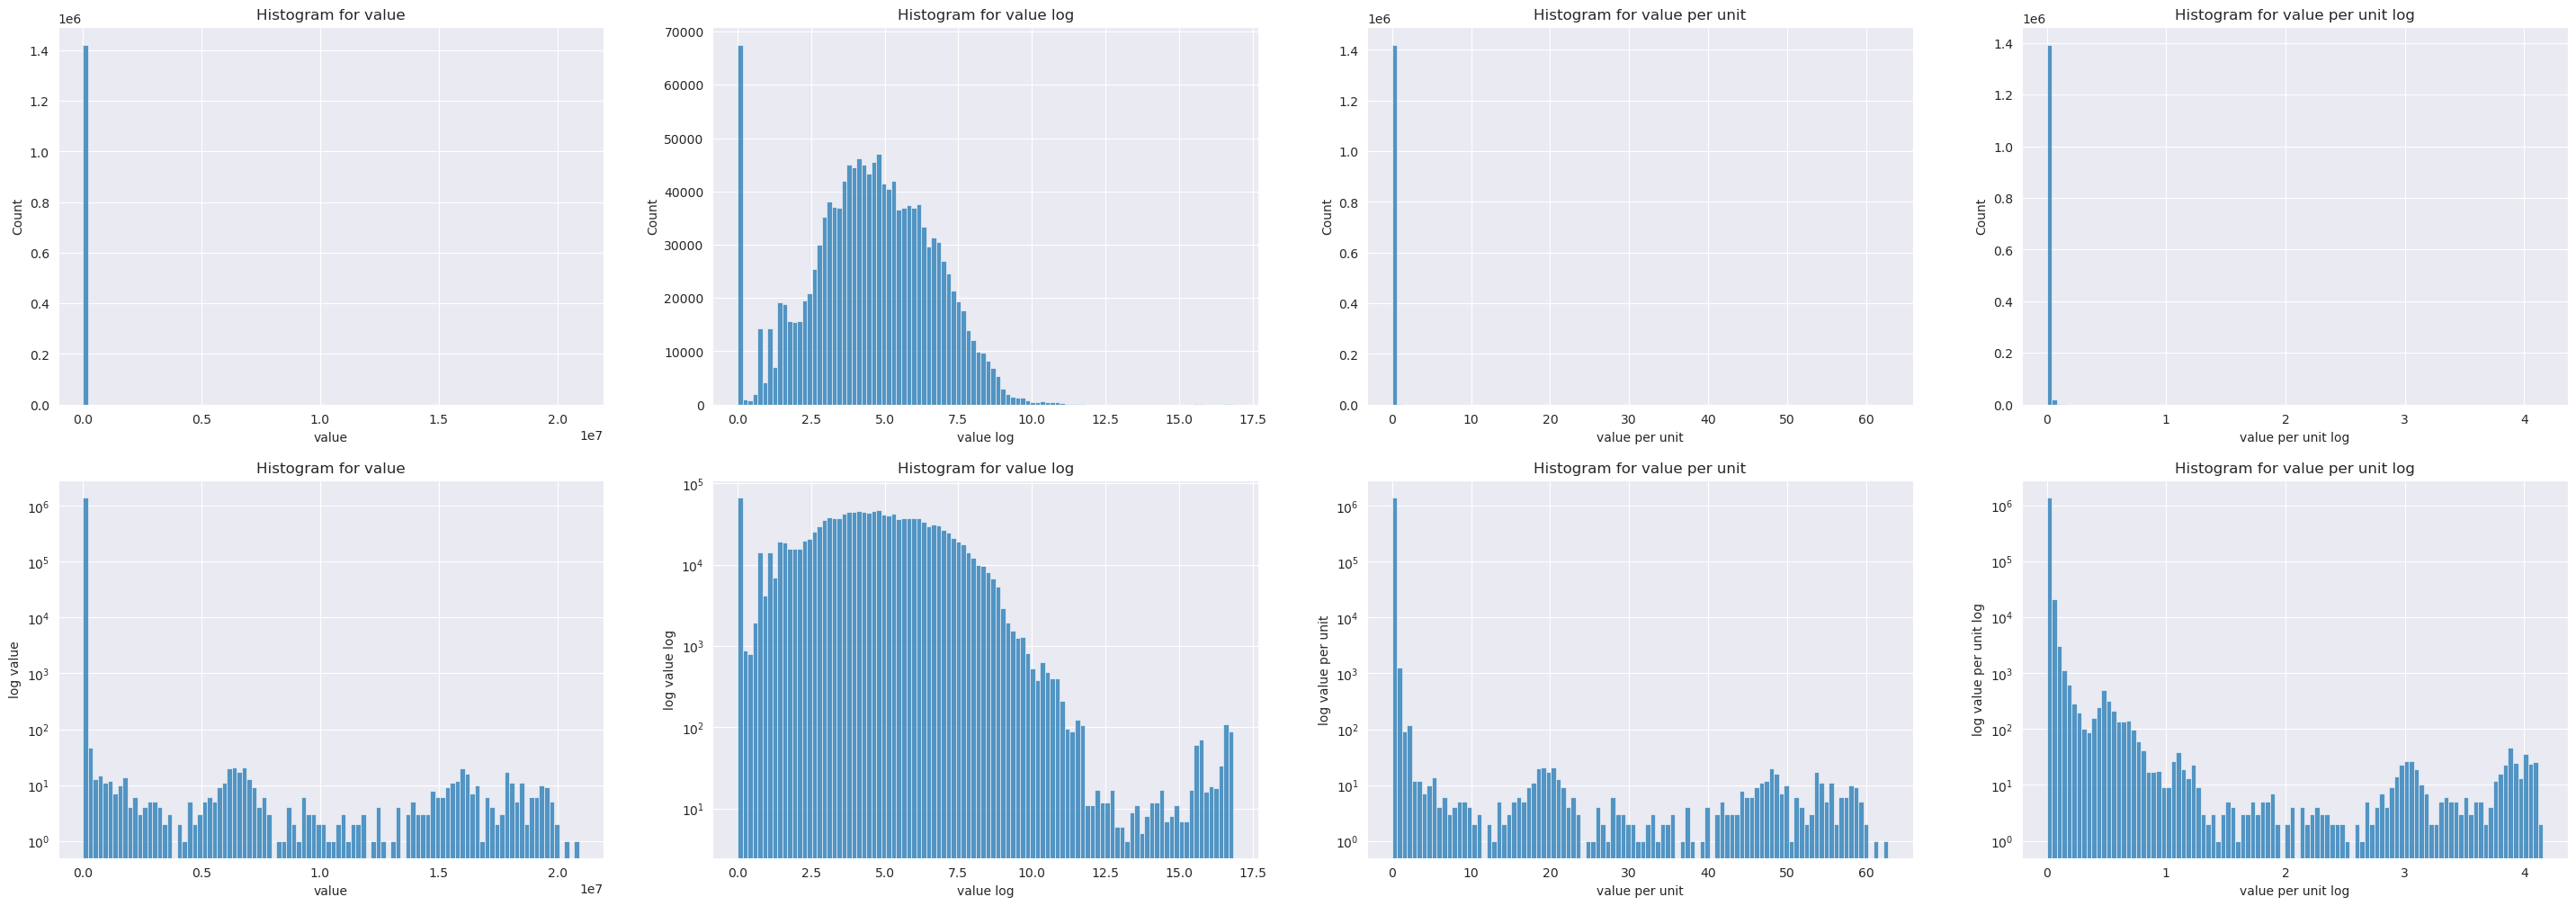

In [37]:
### Target Variable
### Function Plotting Target Value
def check_col_histogram(
        DF:DataFrame,
        targetCol:str,
        set_log:tuple[bool,bool]=(False,False),
        ax=None
) -> None:
    """
    Function to extract the data of a given column and plot a histogram
    :param set_log: Set the axis to log (type:tuple[bool,bool], default:(False,False))
    :param ax: If using as a subplot function, using axes as the image list
    :param targetCol: The target column (type:str)
    :param DF: Data Table (type:pyspark.sql.DataFrame)
    :return: None
    """
    # Extract data
    plotDF = (
        DF.
        select(targetCol)
    )

    # Col name
    _name = re.sub(pattern=r"_",repl=r" ", string=targetCol)

    # Plotting
    if ax is None:
        g = sn.histplot(
            data = plotDF.toPandas(),
            x    = targetCol,
            bins = 100
        )
        plt.xlabel(_name)
        plt.title(f"Histogram for {_name}")

        if set_log[0]:
            # The first element control x-axis
            g.set_xscale("log")
            plt.xlab("log Count")
        elif set_log[1]:
            # The second element control y-axis
            g.set_yscale("log")
            plt.ylabel(f"log {_name}")
    else:
        g = sn.histplot(
            data = plotDF.toPandas(),
            x    = targetCol,
            ax   = ax,
            bins = 100
        )
        ax.set_xlabel(_name)
        ax.set_title(f"Histogram for {_name}")

        if set_log[0]:
            # The first element control x-axis
            g.set_xscale("log")
            ax.set_xlab("log Count")
        elif set_log[1]:
            # The second element control y-axis
            g.set_yscale("log")
            ax.set_ylabel(f"log {_name}")

### Plotting Target Value
## Param Definition
# Column
target_col = col_dtypes_dict["target"][0]
grid_size = 1000

# Data
bin_func = lambda targetCol,gridSize: F.floor(F.col(targetCol)/F.lit(gridSize))*F.lit(gridSize)
plot_df = feature_df\
    .withColumns({
        f"{target_col}_log": F.log(F.col(target_col) + 1),
        f"{target_col}_per_unit": F.col(target_col) / F.col("square_feet"),
        f"{target_col}_per_unit_log": F.log(F.col(f"{target_col}_per_unit") + 1),
    })

# Axis
n_col = 4
n_row = 2
fig_size = (n_col*9,n_row*6)
fig,axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=fig_size)

## Drawing
# Original
check_col_histogram(DF=plot_df, targetCol=f"{target_col}", set_log=(False,False), ax=axes[0,0])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}", set_log=(False,True), ax=axes[1,0])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_log", set_log=(False,False), ax=axes[0,1])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_log", set_log=(False,True), ax=axes[1,1])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_per_unit", set_log=(False,False), ax=axes[0,2])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_per_unit", set_log=(False,True), ax=axes[1,2])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_per_unit_log", set_log=(False,False), ax=axes[0,3])
check_col_histogram(DF=plot_df, targetCol=f"{target_col}_per_unit_log", set_log=(False,True), ax=axes[1,3])
plt.show()

### Conclusion
# I applied three transformations to the target variable: a logarithmic transformation, density normalization (i.e. energy divided by area), and a density log transformation.
# I then plotted histograms both in the original coordinate space and in the space where the Y-axis is on a log scale, in order to examine their distributional characteristics.
# The results show that the target variable exhibits extreme skewness; the logarithmic transformation appears to mitigate this skewness quite well, whereas density normalization and density log transformation do not effectively correct it.
# Next, I plan to compare the overall performance of models trained on the log-transformed target variable versus those trained on the original target variable.

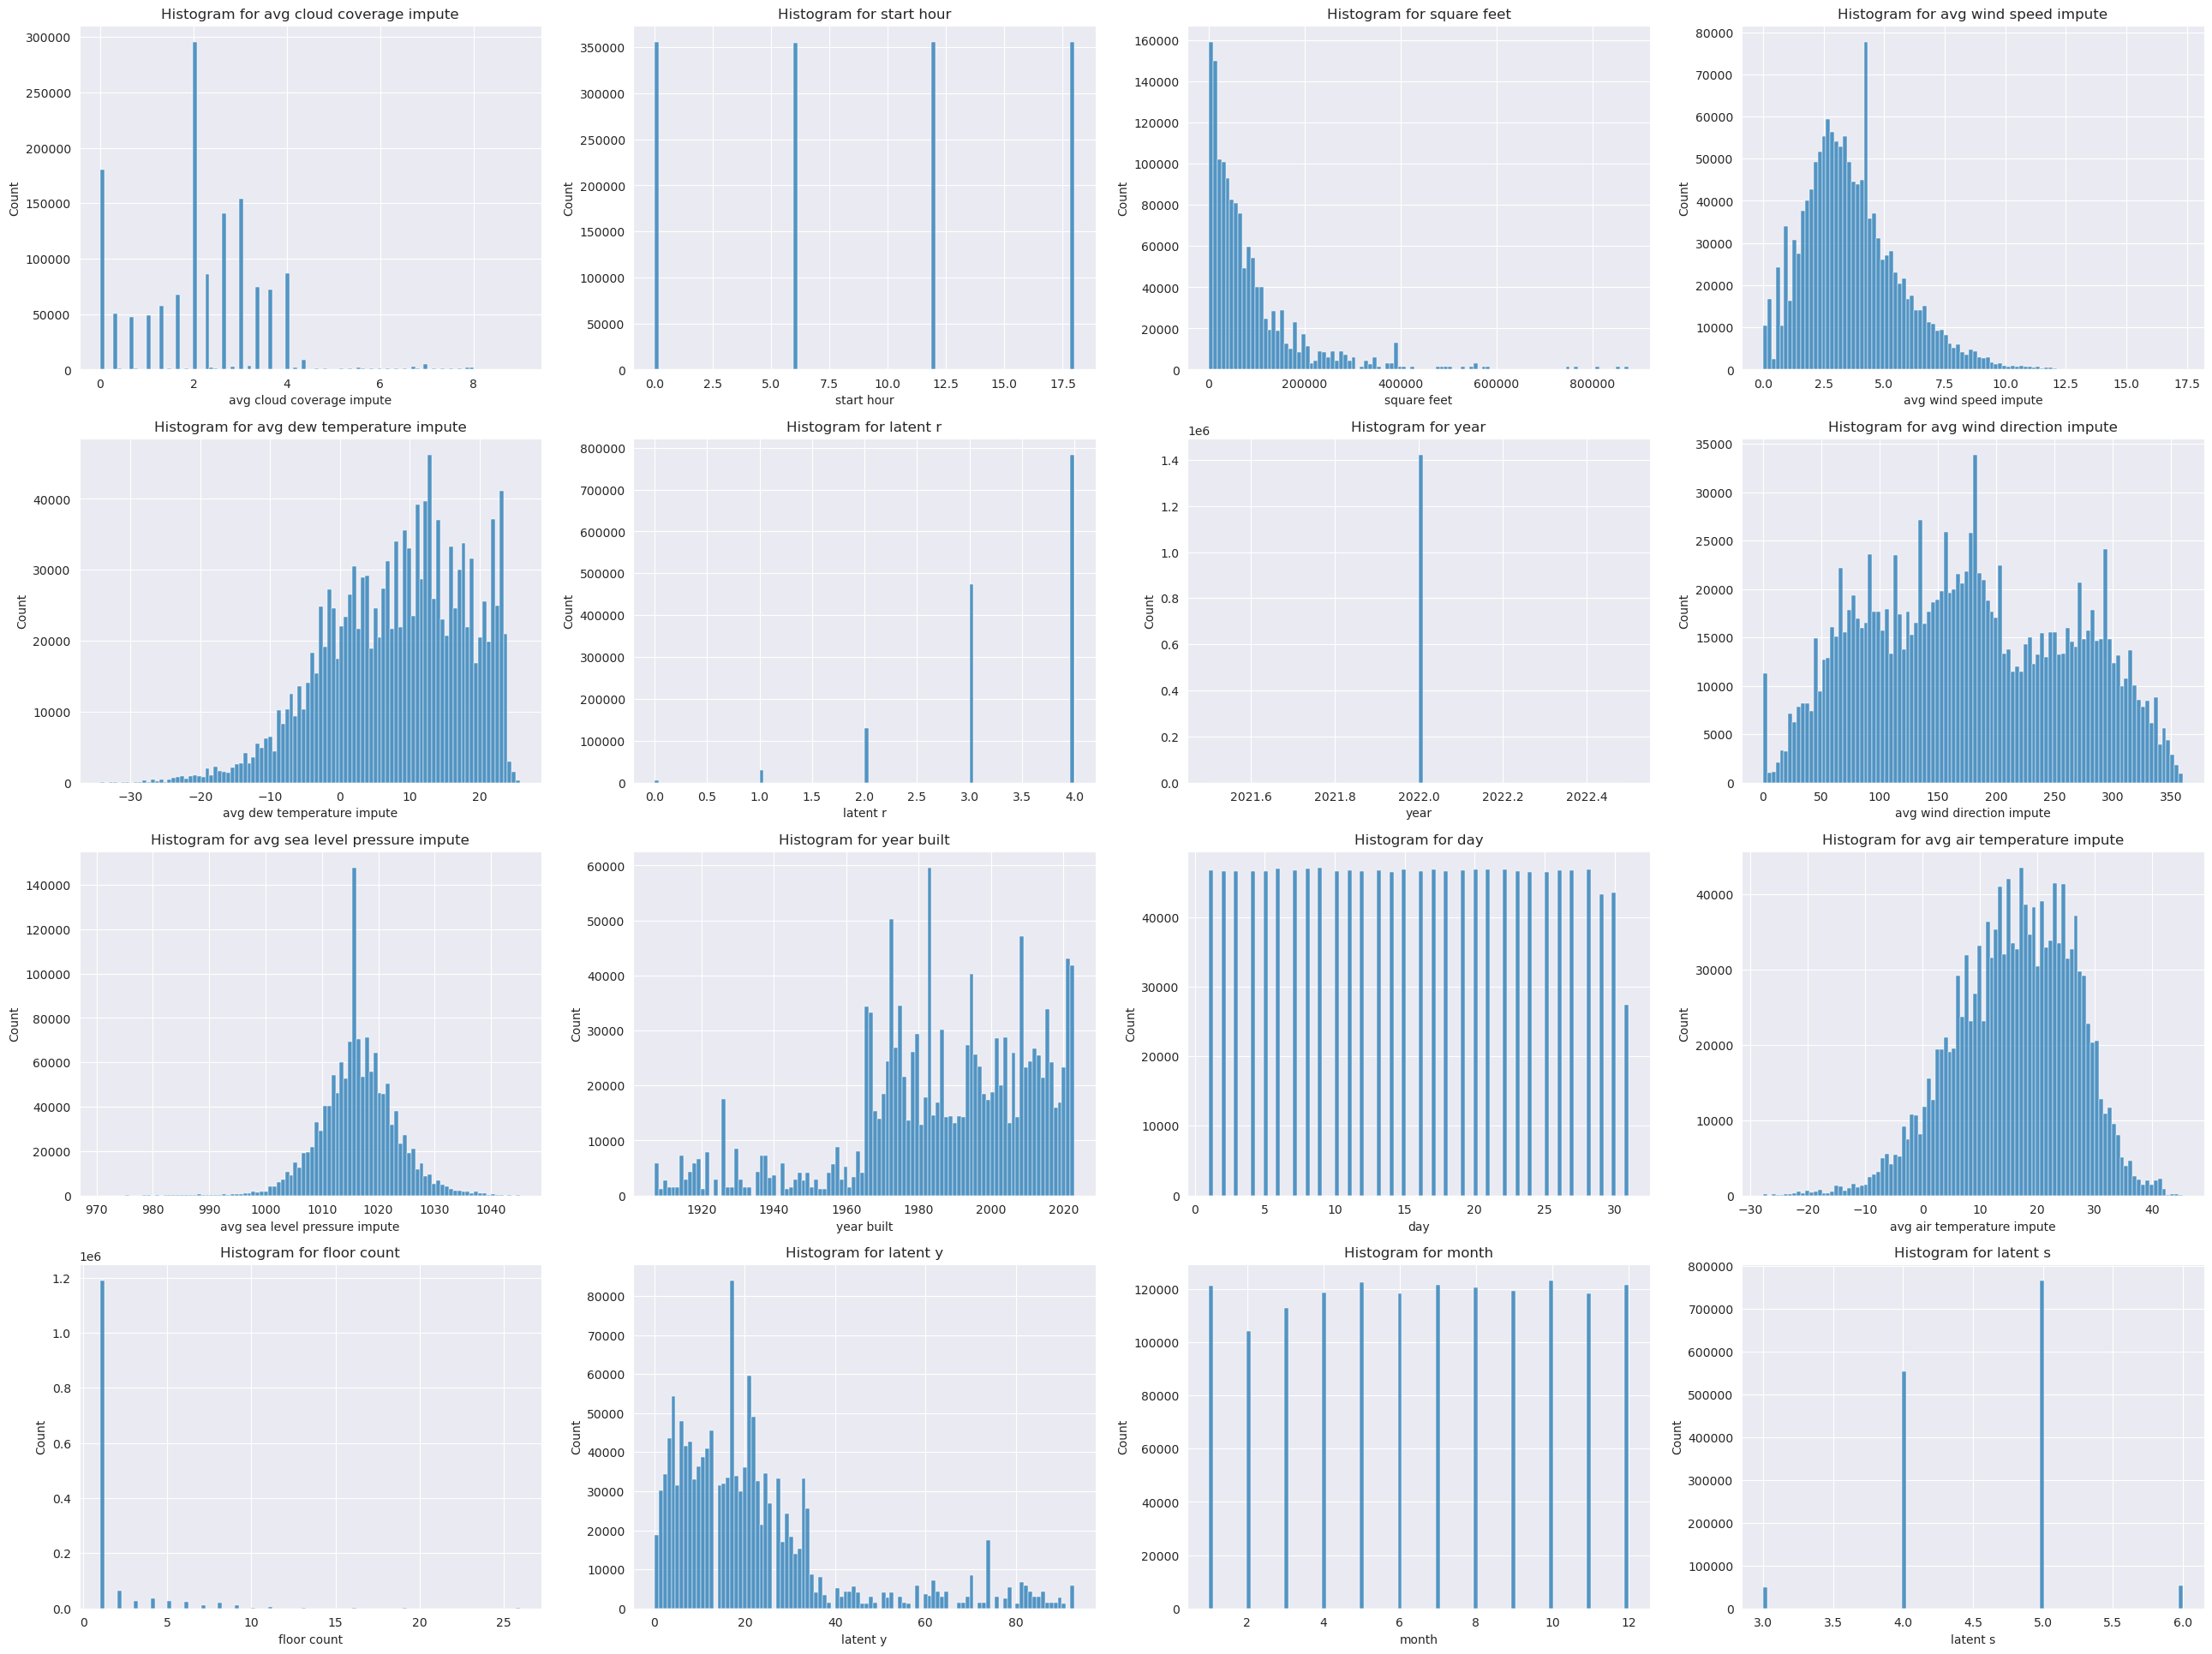

In [38]:
### Numeric Features
## Param Definition
target_columns = col_dtypes_dict["feature"]["num"]
n_col = 4
n_row = math.ceil(len(target_columns)/n_col)
fig_size = (n_col*8,n_row*6)
fig,axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=fig_size)

## Figure Drawing
for _idx,_col in enumerate(target_columns):
    # The grid coordination calculation
    _i = math.floor(_idx/n_col)
    _j = _idx % n_col
    check_col_histogram(DF=feature_df, targetCol=_col, ax=axes[_i,_j])

### Conclusion
# From this analysis, we have identified the following characteristics:
# The floor count variable is extremely skewed, with most observations concentrated at the value 1; we might consider binning it.
# Latent s is concentrated on its central values; a binary binning (two categories) could be considered.
# Year should be removed since it has only a single value and thus conveys no useful information.
# Year built has a strongly left-skewed distribution. We might apply irregular binning and also convert it to the difference from the measurement year (2022) to enhance interpretability.
# Latent y is strongly right-skewed. We could consider including a log-transformed version of latent y to compress its range.
# For square feet, consider using irregular binning to suppress the effect of a few extreme values.
# For cloud coverage (imputed), also consider applying irregular binning to mitigate the influence of outliers.

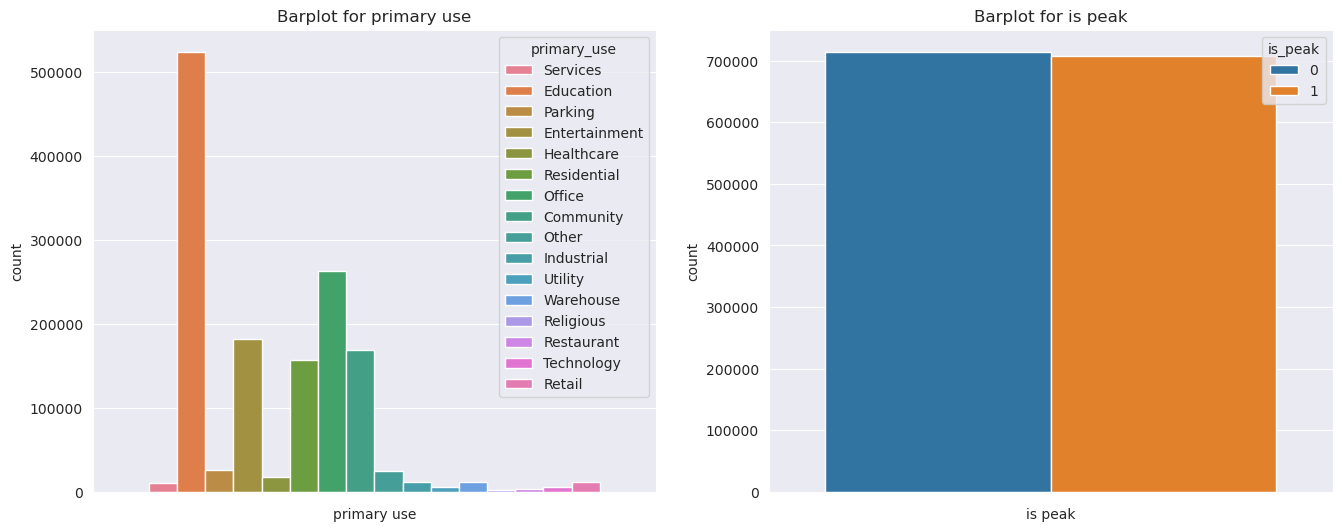

In [39]:
### Classified Variable
### Function Plotting Classified Value
def check_col_barplot(DF:DataFrame, targetCol:str, ax=None):
    """
    Function to extract the data of a given column and plot a barplot
    :param ax: If using as a subplot function, using axes as the image list
    :param targetCol: The target column (type:str)
    :param DF: Data Table (type:pyspark.sql.DataFrame)
    :return: None
    """
    # Extract data
    _plot_data = (
        DF.
        select(targetCol).
        groupBy(targetCol).
        count()
    )

    # Col name
    _name = re.sub(pattern=r"_",repl=r" ", string=targetCol)

    # Plotting
    if ax is None:
        plt.figure(figsize = (12,6))
        sn.barplot(
            data = _plot_data.toPandas(),
            y    = "count",
            hue  = targetCol
        )
        plt.title(f"Barplot for {_name}")
        plt.xlabel(_name)
        plt.show()
    else:
        sn.barplot(
            data = _plot_data.toPandas(),
            y    = "count",
            hue  = targetCol,
            ax   = ax
        )
        ax.set_title(f"Barplot for {_name}")
        ax.set_xlabel(_name)
### Plotting Classified Value
## Param Definition
target_columns = col_dtypes_dict["feature"]["str"] + col_dtypes_dict["feature"]["bool"]
n_col = 2
n_row = math.ceil(len(target_columns)/n_col)
fig_size = (n_col*8,n_row*6)

fig,axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=fig_size)

## Figure Drawing
for _idx,_col in enumerate(target_columns):
    # The grid coordination calculation
    check_col_barplot(DF=feature_df, targetCol=_col, ax=axes[_idx])

# Findings from data exploration:
# The “primary_use” categories are extremely imbalanced. Beyond the top five categories, all other categories have very few samples.
# Consider merging these minor categories into one of the top five to reduce sparsity.
# Because the distribution of the target variable may differ across categories,
# We should further analyze the target value distributions within each “primary_use” category.
# Merge categories that exhibit similar distributional behavior to improve model robustness.

#### **1.3.2.2. Bivariate Analysis**

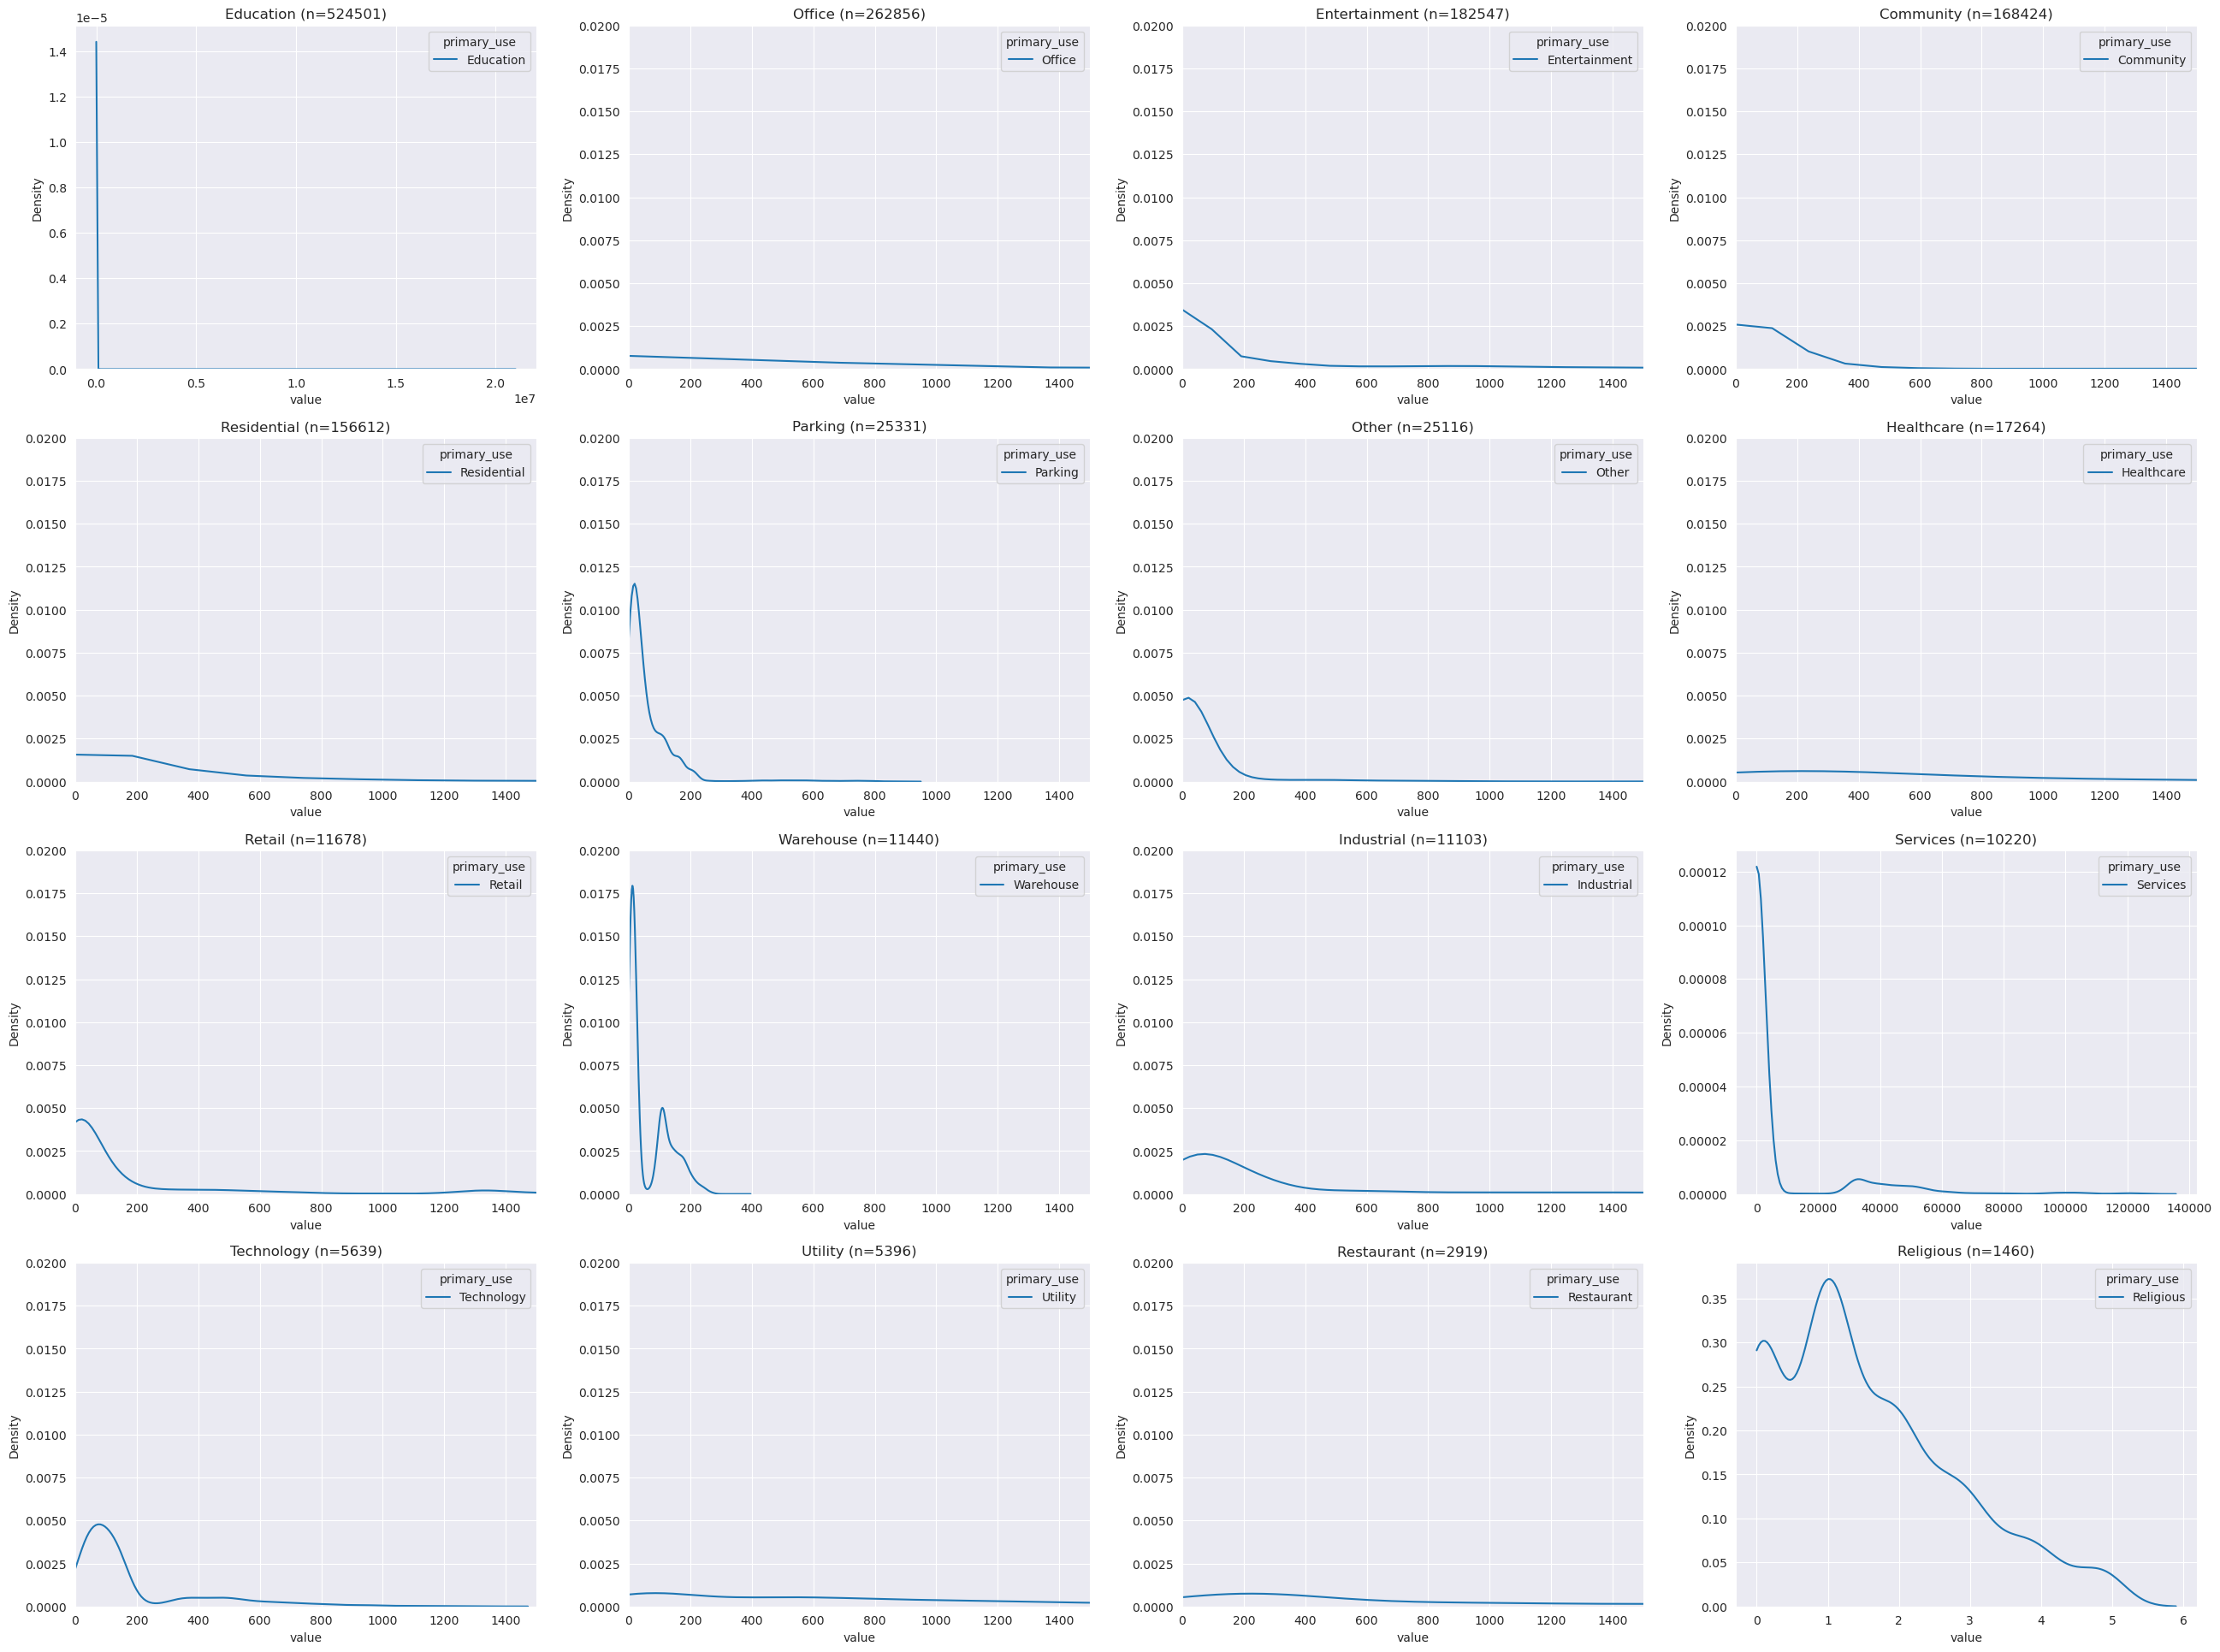

In [40]:
### Target Value and Primary Use
use_class = feature_df.select("primary_use").groupBy("primary_use").count().orderBy(F.col("count").desc()).toPandas()
n_col = 4
n_row = math.ceil(use_class.shape[0] / n_col)
fig_size = (n_col*8,n_row*6)
fig,axes = plt.subplots(nrows=n_row, ncols=n_col, figsize = fig_size)
for _idx in range(use_class.shape[0]):
    _class = use_class.iloc[_idx,0]
    _count = use_class.iloc[_idx,1]
    _i = math.floor(_idx/n_col)
    _j = _idx % n_col
    sn.kdeplot(
        data = feature_df.select(["value","primary_use"]).filter(F.col("primary_use") == _class).toPandas(),
        x    = "value",
        hue  = "primary_use",
        common_norm = False,
        ax   = axes[_i,_j],
        clip = (0.0,None)
    )
    axes[_i,_j].set_title(f"{_class} (n={_count})")
    if _class not in ["Education","Services","Religious"]:
        axes[_i,_j].set_xlim((0.0,1.5e03))
        axes[_i,_j].set_ylim((0.0,2e-02))
plt.show()
## Findings from category analysis:
# “Education” has a distribution pattern very similar to “Warehouse”, “Services”, and “Parking”.
# Consider merging these into a single combined category.
# All remaining minor categories can be consolidated into “Residential” in order to balance class frequencies.

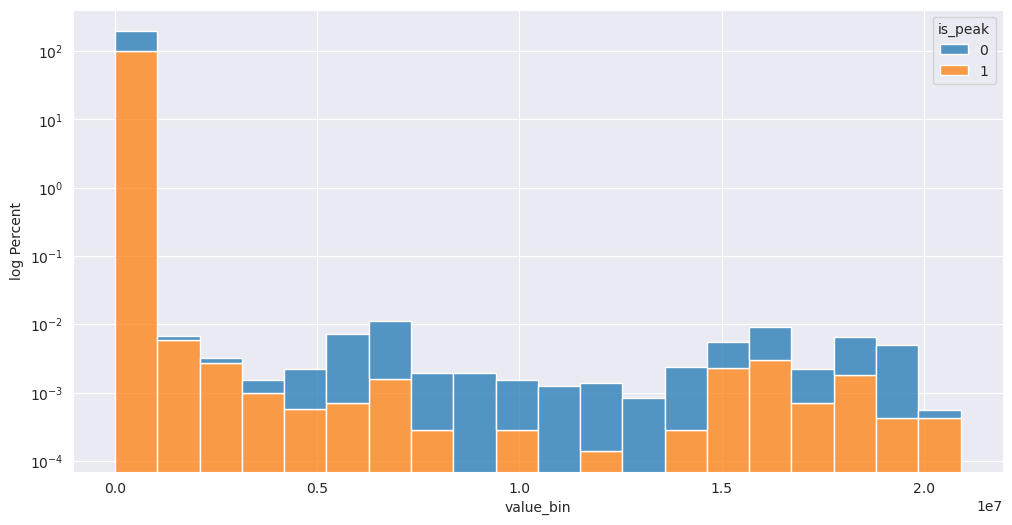

In [41]:
### is_Peak and Target Value
## Transformation control
is_bin = True

## Column
target_col = "value"
feature_col = "is_peak"
plot_cols = [f"{target_col}_bin",feature_col] if is_bin else [target_col,feature_col]

## Data
grid_size = 1000
plot_df = feature_df.withColumn(
    colName=plot_cols[0],
    col=F.floor(F.col(target_col)/F.lit(grid_size))*F.lit(grid_size)
)

## Axis
plt.figure(figsize = (12,6))
# fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(24,6))

### Drawing
g1 = sn.histplot(
    data = plot_df.select(plot_cols).toPandas(),
    x    = plot_cols[0],
    bins = 20,
    stat = "percent",
    hue  = plot_cols[1],
    multiple = "stack",
    common_norm = False,
    # hue  = "is_peak",
    # clip = (0.0,None),
    # ax   = axes[0]
)
g1.set_yscale("log")
plt.ylabel("log Percent")
plt.show()
## Observations:
# Overall, the electricity consumption in peak months is concentrated at both extremes of the value range,
# whereas in non-peak months, the consumption is concentrated more toward the middle of the range.
# There is a clear distinction between these two groups.

## **1.4 Feature Transformation**

In [9]:
### Library
## Loading
from pyspark.ml.feature import Bucketizer

In [43]:
### Feature engineer function
def feature_creation(DF:DataFrame):
    return DF\
        .withColumns({
            ## Feature creation and transformation
            "year_use" : F.col("year") - F.col("year_built"),
            "primary_use_modify": F.when((F.col("primary_use") == "Warehouse") |
                                         (F.col("primary_use") == "Services") |
                                         (F.col("primary_use") == "Parking"),
                                         "Education")\
                                   .when((F.col("primary_use") != "Community") &
                                         (F.col("primary_use") != "Entertainment") &
                                         (F.col("primary_use") != "Residential") &
                                         (F.col("primary_use") != "Office") &
                                         (F.col("primary_use") != "Education") &
                                         (F.col("primary_use") != "Warehouse") &
                                         (F.col("primary_use") != "Services") &
                                         (F.col("primary_use") != "Parking"),
                                         "Residential")\
                                    .otherwise(F.col("primary_use")),
            "value_log": F.log(F.col("value") + 1)
        })\
        .drop("year")\
        .drop("year_built")\
        .drop("primary_use")
feature_df02 = feature_creation(DF=feature_df)

In [44]:
### Quantile Bucketing Function
def quantile_bucket_splits(
        DF:DataFrame,
        targetCol:str,
        bucketRange:tuple,
        quantileList:list=None
) -> list:
    """
    Get the quantile bucket splits.
    :param DF: Target DataFrame (type:pyspark.sql.DataFrame)
    :param targetCol: Target feature (type:str)
    :param bucketRange: The bucket value range, e.g., greater than 35 -> (35,None) (type:tuple)
    :param quantileList: The quantile list, default is 5 equal quantile bucketing (type:list)
    :return: The bucket break point list (type:list)
    """

    if quantileList is None and quantileList != []:
        quantileList = [.2,.4,.6,.8]

    ## Quantile Bucketing for year_use
    targetFeature = DF.select(F.col(targetCol).cast("double").alias(targetCol))

    if bucketRange[0] is None and bucketRange[1] is not None:
        # Pattern like [None,breakPoint]
        breakPoint = bucketRange[1]
        targetRange = targetFeature.filter(F.col(targetCol) <= breakPoint)
        remainRange = targetFeature.filter(F.col(targetCol) >  breakPoint)
    elif bucketRange[1] is None and bucketRange[0] is not None:
        # Pattern like [breakPoint,None]
        breakPoint = bucketRange[0]
        targetRange = targetFeature.filter(F.col(targetCol) >= breakPoint)
        remainRange = targetFeature.filter(F.col(targetCol) <  breakPoint)
    else:
        raise ValueError("The range is invalid, please check your range.")

    if quantileList != []:
        quantileBucket = list(targetRange\
            .toPandas()\
            .quantile(quantileList)\
            .iloc[:,0]) # Get the point list
    else:
        quantileBucket = [breakPoint]

    normalBucket = list(remainRange\
        .distinct()\
        .toPandas()\
        .iloc[:,0])

    bucketSplits = [float(_element) + 1e-06 for _element in normalBucket + quantileBucket]
    bucketSplits.sort()

    return [-float("inf")] + bucketSplits + [float("inf")]

In [45]:
### Feature bucketing
## Binary Bucketing for floor_count
floor_count_bucket = [-float("inf"),1.1,float("inf")]

## Binary Bucketing for latent_s
latent_s_bucket = [-float("inf"),4.5,float("inf")]

## Quantile Bucketing for latent_y
latent_y_bucket = quantile_bucket_splits(
    DF          = feature_df02,
    targetCol   = "latent_y",
    bucketRange = (35,None)
)

## Quantile bucket for year_use
year_use_bucket = quantile_bucket_splits(
    DF          = feature_df02,
    targetCol   = "year_use",
    bucketRange = (57,None)
)

## Quantile bucket for avg_cloud_coverage_impute
avg_cloud_coverage_impute_bucket = quantile_bucket_splits(
    DF          = feature_df02,
    targetCol   = "avg_cloud_coverage_impute",
    bucketRange = (5,None),
    quantileList= [0.5]
)

## Bucket Params
input_cols_bucket  = ["year_use","floor_count","latent_s","latent_y",
                      "avg_cloud_coverage_impute"]
output_cols_bucket = [f"{_col}_bucket" for _col in input_cols_bucket]
splits = [year_use_bucket,floor_count_bucket,
          latent_s_bucket,latent_y_bucket,
          avg_cloud_coverage_impute_bucket]

## Bucketing
bucketer = Bucketizer(
    inputCols   = input_cols_bucket,
    outputCols  = output_cols_bucket,
    splitsArray = splits
)
feature_df03 = bucketer.transform(dataset=feature_df02)

## Special Bucketing
## Square_feet
# I replace every square feet greater than 400000 to 400000,
# than add two bool column as: square_feet_4e05_6e05 and square_feet_6e05_inf
feature_df04 = feature_df03\
    .withColumns({
        "is_square_feet_4e05_6e05": F.when(
            condition=(F.col("square_feet")>4e05) & (F.col("square_feet")<=6e05),
            value=1
        ).otherwise(value=0),
        "is_square_feet_6e05_inf": F.when(
            condition=(F.col("square_feet")>6e05),
            value=1
        ).otherwise(value=0),
        "square_feet_bucket": F.when(
            condition=F.col("square_feet")>4e05,
            value=4e05
        ).otherwise(value=F.col("square_feet"))
    })\
    .drop("year_use")\
    .drop("latent_s")\
    .drop("latent_y")\
    .drop("square_feet")\
    .drop("floor_count")\
    .drop("avg_cloud_coverage_impute")

## **1.5 Multivariate Analysis and comparison**

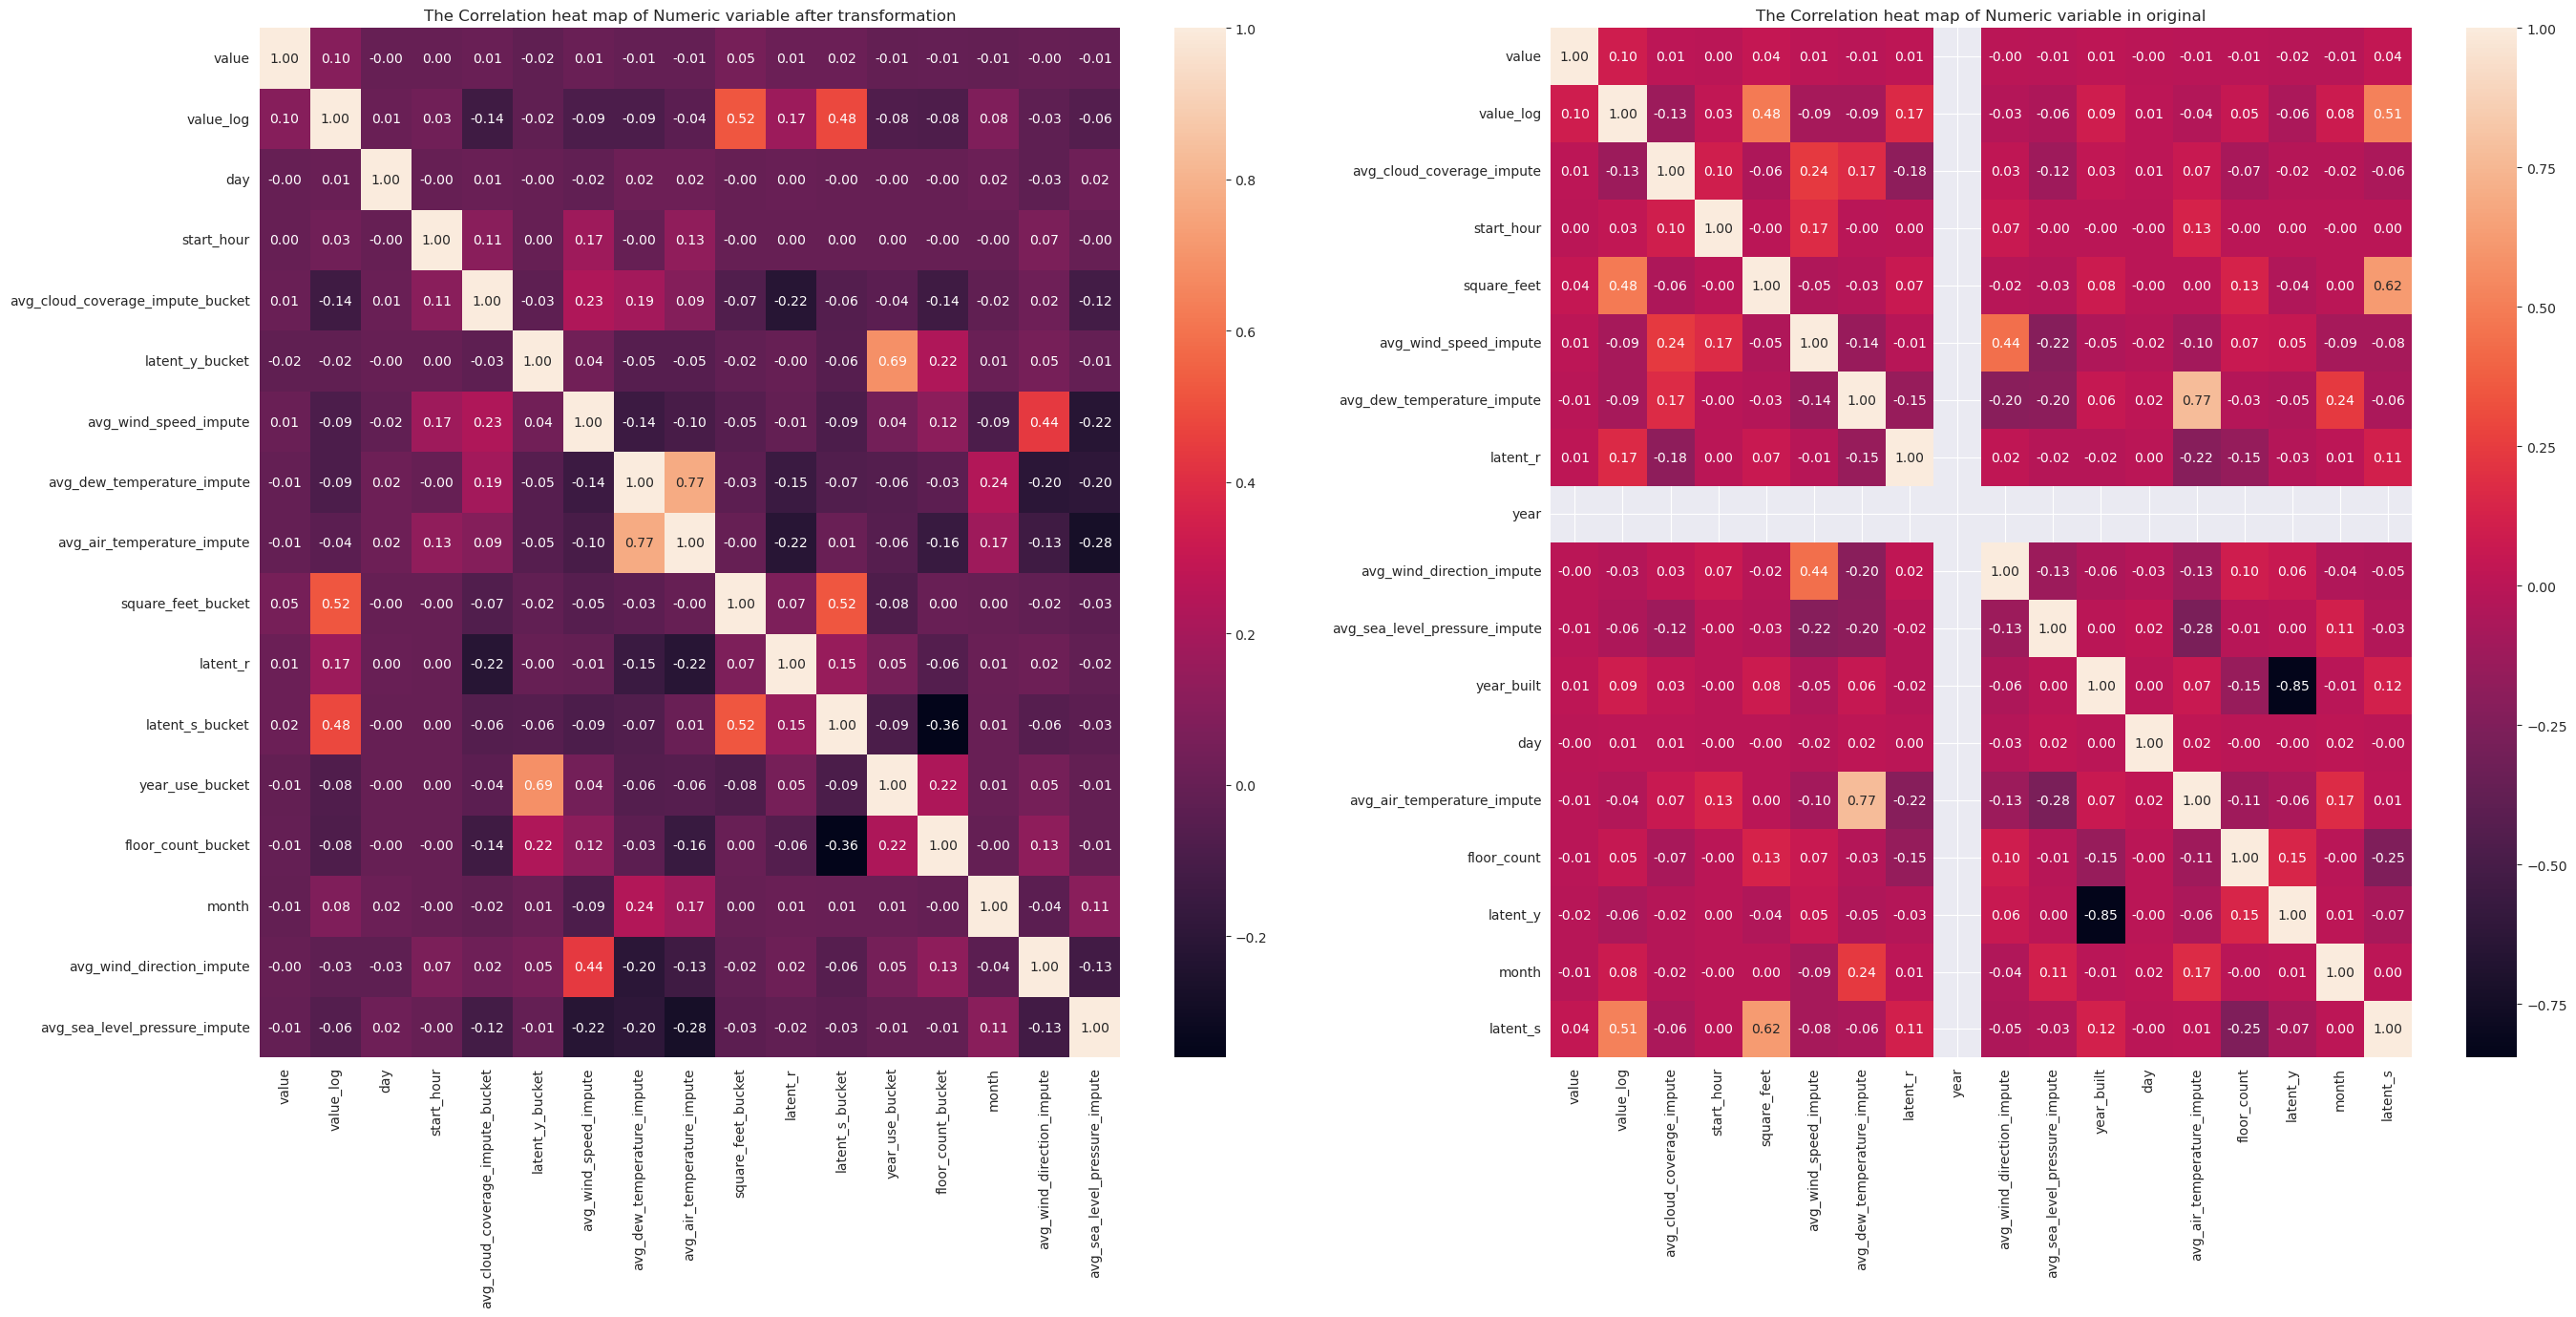

In [46]:
col_dtypes_dict02 = type_definition(DF=feature_df04, target_col=["value","value_log"])
### Visualization
fig,axes = plt.subplots(ncols=2, nrows=1, figsize = (32,14))
plot_df = feature_df04\
    .select([
        F.col(_col).cast("float") for _col in col_dtypes_dict02["target"] + col_dtypes_dict02["feature"]["num"]
    ]).toPandas().corr()
sn.heatmap(
    data  = plot_df,
    annot = True,
    fmt   = ".2f",
    ax    = axes[0]
)
axes[0].set_title("The Correlation heat map of Numeric variable after transformation")
plot_df = feature_df\
    .withColumns({
        "value_log": F.log(F.col("value") + 1)
    })\
    .select([
        F.col(_col).cast("float") for _col in col_dtypes_dict["target"] + ["value_log"] + col_dtypes_dict["feature"]["num"]
    ]).toPandas().corr()
sn.heatmap(
    data  = plot_df,
    annot = True,
    fmt   = ".2f",
    ax    = axes[1]
)
axes[1].set_title("The Correlation heat map of Numeric variable in original")
plt.show()
## Attention
# I will only use this heat map to decide whether to delete feature that have high correlation
# since the Pearson correlation coefficient can only find the linear correlation.

Comparing correlation heatmaps before and after transformation, we found that:
1. Log-transforming the target greatly boosts overall correlation:
   latent_s vs original target: from $0.04 \rightarrow 0.51$ vs log target: $0.48$.
2. Most feature transformations raise target correlations:
   e.g. square_feet’s r(original): $0.04 \rightarrow 0.05$, r(log target): $0.48 \rightarrow 0.52$.
   But some features don’t always improve — latent_s’s r(original) drops $0.04 \rightarrow 0.02$, though its r(log target) improves.
3. Noticeable inter-feature correlation exists:
   dew_temperature & air_temperature: $r \approx 0.77$,
   latent_s & square_feet: from $0.62 \rightarrow 0.54$.
4. Some features (e.g. wind_direction) have very weak correlation with target;
   if tree models rate them low in importance, they can be removed.

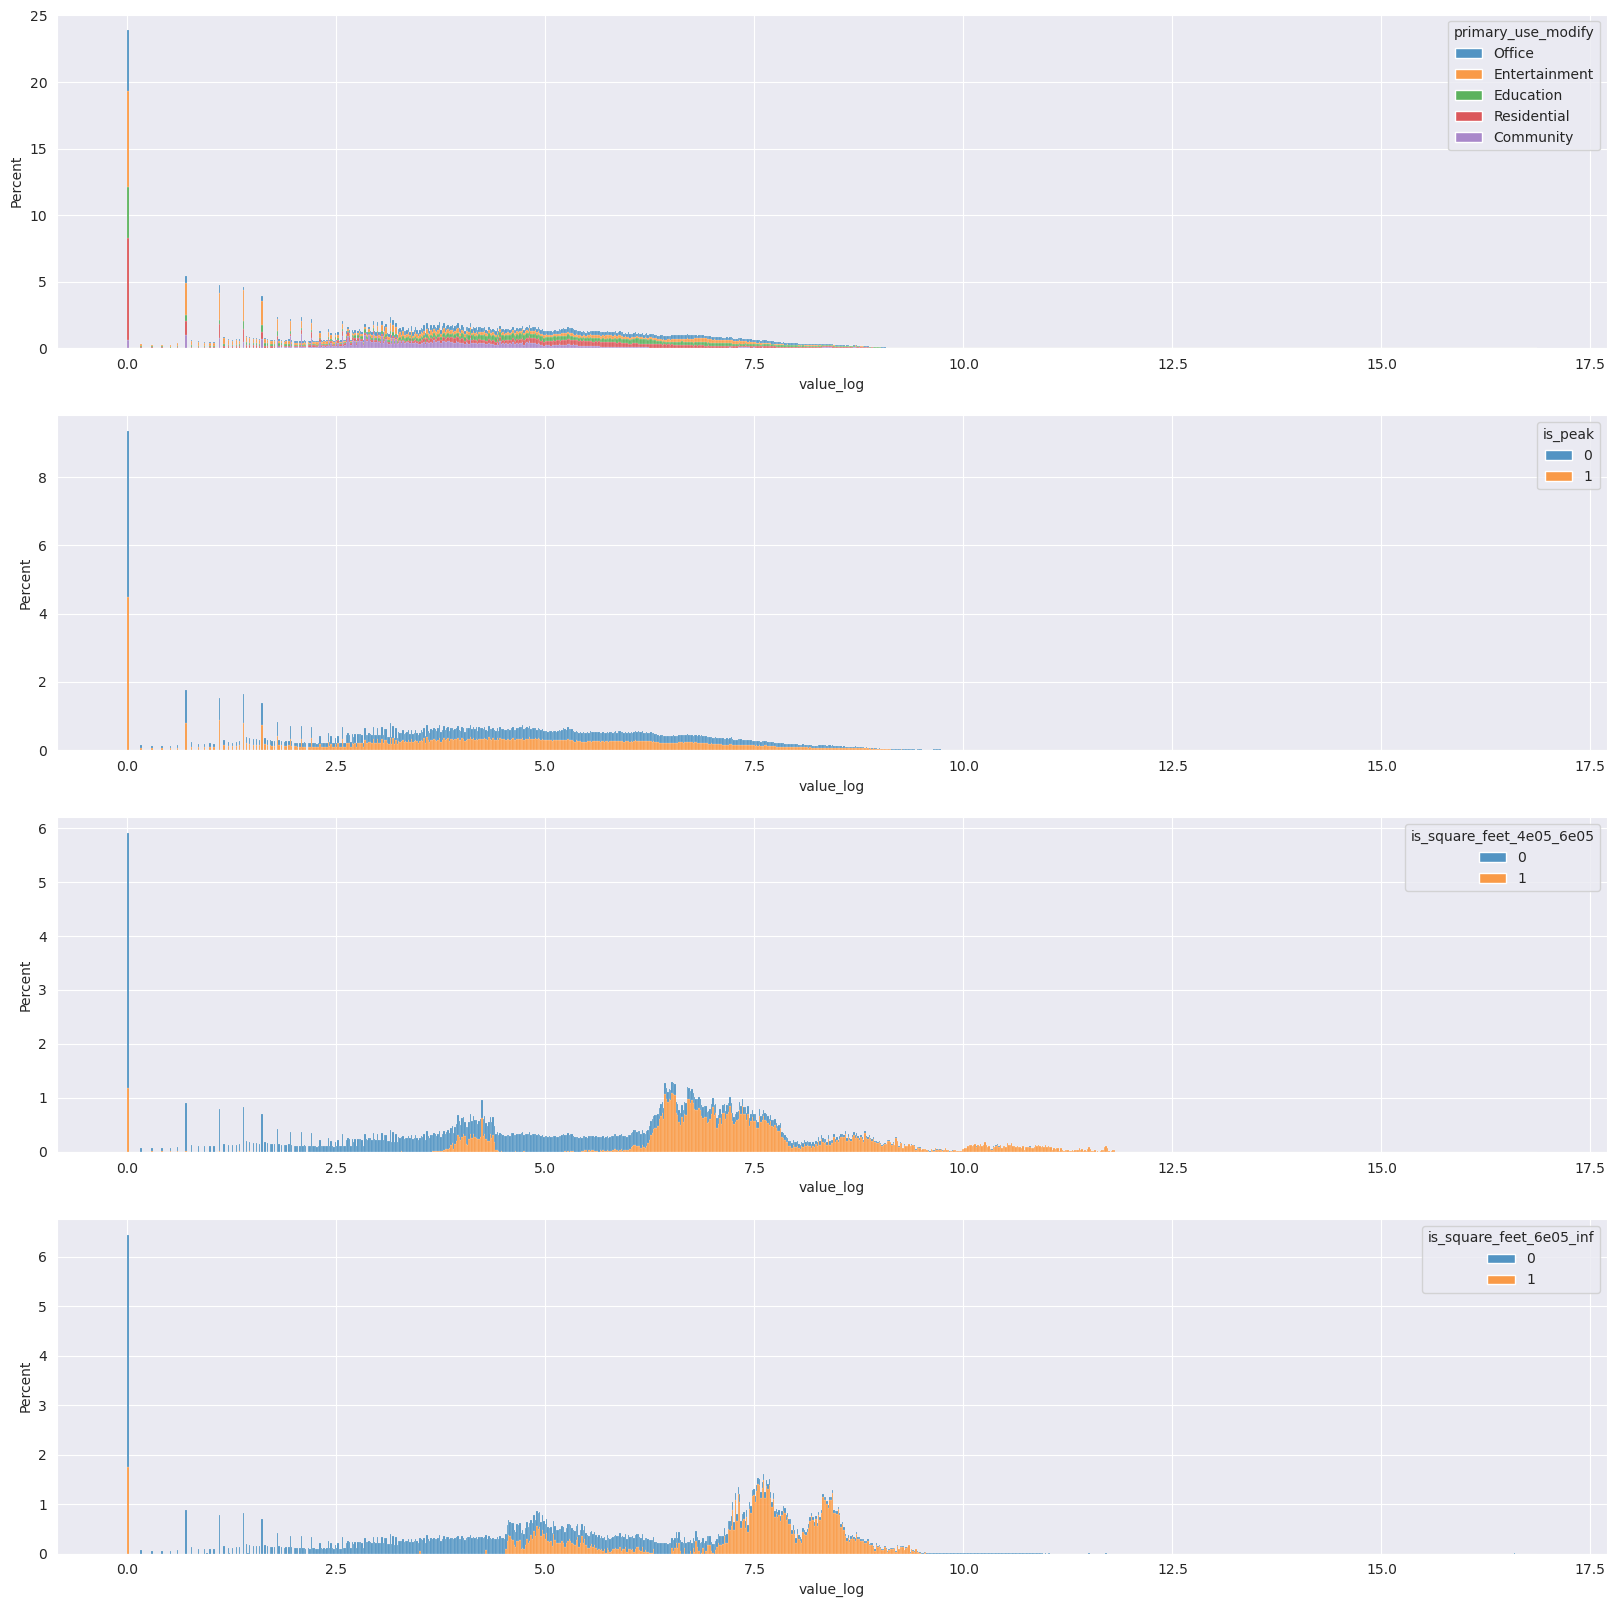

In [48]:
### Density Plot with log target value
def kde_plot(DF:DataFrame, targetCol:str, featureCols:list):
    plotDF = DF\
        .select(featureCols + [targetCol])\
        .withColumns({
            f"{targetCol}_log": F.log(F.col(targetCol) + 1),
        })\
    ### Plotting
    # common_norm = False is to make sure seaborn normalize each group separately instead of
    # keeping area under every curve to be 1.
    # I learn this from: https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
    _fig,_axes = plt.subplots(nrows=len(featureCols),ncols=1, figsize=(20,20))
    for _idx,_col in enumerate(featureCols):
        sn.histplot(
            data = plotDF.select([_col,f"{targetCol}_log"]).toPandas(),
            x    = f"{targetCol}_log",
            hue  = _col,
            ax   = _axes[_idx],
            bins = 1000,
            multiple = "stack",
            stat = "percent",
            common_norm = False
        )
    plt.show()
### Cols definition
str_cols = col_dtypes_dict02["feature"]["str"] + col_dtypes_dict02["feature"]["bool"]
target   = "value"

### Visualization
kde_plot(DF=feature_df04, featureCols=str_cols, targetCol=target)

By comparing the distributions of the log-transformed target variable across categories (via a stacked area chart—where each colored area denotes the proportion of a category), I observed:
1. Within primary_use, the log target distributions vary across categories. The Education category exhibits the broadest spread and tends toward higher values, while Community generally skews toward lower values.
2. For the is_peak feature, the two classes (peak vs. non-peak months) show little apparent difference in log target distributions. Their effect may only emerge when modeled in a high-dimensional space (e.g. via tree models).
3. Looking at the second and third variables together, especially for the “category = $1$” group: the records with area between $400,000$ and $600,000$ tend to have slightly lower target values compared to those above $600,000$, which aligns with expectations.

In [49]:
feature_df04.write.parquet("../Precomputed02", mode="overwrite")

---

# **Part 2. Feature extraction and ML training**

In [50]:
### Attention
# Since I have done the transformation before this part,
# I will copy the context from before.
# For further detail, please refer to the corresponding part before

## **2.1 Discussion of the feature selection**

For the target variable, I will build models using both the original values and the logarithmic transformation, and evaluate predictive performance in terms of RMSLE and the prediction distribution.

For the feature variables, I applied the following transformations:
1. For Primary Use, based on observed distributions, I merged Warehouse, Services, and Parking into the Education category; all remaining minor categories were absorbed into Residential (see section 1.3.2.2 Bivariate Analysis – Target Value and Primary Use).
2. For year_use, floor_count, latent_s, latent_y, square_feet, and avg_cloud_coverage_impute, I applied bucketing (binning) and included supplementary boolean indicator variables. This allows suppression of extreme values while preserving useful information (see 1.3.2.1 Univariate Analysis – Numeric Features and 1.3.2.3 Feature Transformation – Feature Bucketing).
3. I dropped the year variable, since it contains no informative variance.
4. I created a new variable year_use, computed as year − year_built.

### **2.1.2 Data Transformation**

In [51]:
### Attention
# Since I have done the transformation before this part,
# I will copy the context from before.
# For further detail, please refer to the corresponding part before

In [52]:
### Feature engineer function
def feature_creation(DF:DataFrame):
    return DF\
        .withColumns({
            ## Feature creation and transformation
            "year_use" : F.col("year") - F.col("year_built"),
            "primary_use_modify": F.when((F.col("primary_use") == "Warehouse") |
                                         (F.col("primary_use") == "Services") |
                                         (F.col("primary_use") == "Parking"),
                                         "Education")\
                                   .when((F.col("primary_use") != "Community") &
                                         (F.col("primary_use") != "Entertainment") &
                                         (F.col("primary_use") != "Residential") &
                                         (F.col("primary_use") != "Office") &
                                         (F.col("primary_use") != "Education") &
                                         (F.col("primary_use") != "Warehouse") &
                                         (F.col("primary_use") != "Services") &
                                         (F.col("primary_use") != "Parking"),
                                         "Residential")\
                                    .otherwise(F.col("primary_use")),
            "value_log": F.log(F.col("value") + 1)
        })\
        .drop("year")\
        .drop("year_built")\
        .drop("primary_use")

In [53]:
### Quantile Bucketing Function
def quantile_bucket_splits(
        DF:DataFrame,
        targetCol:str,
        bucketRange:tuple,
        quantileList:list=None
) -> list:
    """
    Get the quantile bucket splits.
    :param DF: Target DataFrame (type:pyspark.sql.DataFrame)
    :param targetCol: Target feature (type:str)
    :param bucketRange: The bucket value range, e.g., greater than 35 -> (35,None) (type:tuple)
    :param quantileList: The quantile list, default is 5 equal quantile bucketing (type:list)
    :return: The bucket break point list (type:list)
    """

    if quantileList is None and quantileList != []:
        quantileList = [.2,.4,.6,.8]

    ## Quantile Bucketing for year_use
    targetFeature = DF.select(F.col(targetCol).cast("double").alias(targetCol))

    if bucketRange[0] is None and bucketRange[1] is not None:
        # Pattern like [None,breakPoint]
        breakPoint = bucketRange[1]
        targetRange = targetFeature.filter(F.col(targetCol) <= breakPoint)
        remainRange = targetFeature.filter(F.col(targetCol) >  breakPoint)
    elif bucketRange[1] is None and bucketRange[0] is not None:
        # Pattern like [breakPoint,None]
        breakPoint = bucketRange[0]
        targetRange = targetFeature.filter(F.col(targetCol) >= breakPoint)
        remainRange = targetFeature.filter(F.col(targetCol) <  breakPoint)
    else:
        raise ValueError("The range is invalid, please check your range.")

    if quantileList != []:
        quantileBucket = list(targetRange\
            .toPandas()\
            .quantile(quantileList)\
            .iloc[:,0]) # Get the point list
    else:
        quantileBucket = [breakPoint]

    normalBucket = list(remainRange\
        .distinct()\
        .toPandas()\
        .iloc[:,0])

    bucketSplits = [float(_element) + 1e-06 for _element in normalBucket + quantileBucket]
    bucketSplits.sort()

    return [-float("inf")] + bucketSplits + [float("inf")]

In [54]:
### Feature bucketing
## Binary Bucketing for floor_count
# floor_count_bucket = [-float("inf"),1.1,float("inf")]

## Binary Bucketing for latent_s
# latent_s_bucket = [-float("inf"),4.5,float("inf")]

## Quantile Bucketing for latent_y
# latent_y_bucket = quantile_bucket_splits(
#     DF          = feature_df02,
#     targetCol   = "latent_y",
#     bucketRange = (35,None)
# )

## Quantile bucket for year_use
# year_use_bucket = quantile_bucket_splits(
#     DF          = feature_df02,
#     targetCol   = "year_use",
#     bucketRange = (57,None)
# )

## Quantile bucket for avg_cloud_coverage_impute
# avg_cloud_coverage_impute_bucket = quantile_bucket_splits(
#     DF          = feature_df02,
#     targetCol   = "avg_cloud_coverage_impute",
#     bucketRange = (5,None),
#     quantileList= [0.5]
# )

## Bucket Params
# input_cols_bucket  = ["year_use","floor_count","latent_s","latent_y",
#                       "avg_cloud_coverage_impute"]
# output_cols_bucket = [f"{_col}_bucket" for _col in input_cols_bucket]
# splits = [year_use_bucket,floor_count_bucket,
#           latent_s_bucket,latent_y_bucket,
#           avg_cloud_coverage_impute_bucket]

## Bucketing
# bucketer = Bucketizer(
#     inputCols   = input_cols_bucket,
#     outputCols  = output_cols_bucket,
#     splitsArray = splits
# )
# feature_df03 = bucketer.transform(dataset=feature_df02)

## Special Bucketing
## Square_feet
# I replace every square feet greater than 400000 to 400000,
# then add two bool column as: square_feet_4e05_6e05 and square_feet_6e05_inf
# feature_df_final = feature_df03\
#     .withColumns({
#         "is_square_feet_4e05_6e05": F.when(
#             condition=(F.col("square_feet")>4e05) & (F.col("square_feet")<=6e05),
#             value=1
#         ).otherwise(value=0),
#         "is_square_feet_6e05_inf": F.when(
#             condition=(F.col("square_feet")>6e05),
#             value=1
#         ).otherwise(value=0),
#         "square_feet_bucket": F.when(
#             condition=F.col("square_feet")>4e05,
#             value=4e05
#         ).otherwise(value=F.col("square_feet"))
#     })\
#     .drop("year_use")\
#     .drop("latent_s")\
#     .drop("latent_y")\
#     .drop("square_feet")\
#     .drop("floor_count")\
#     .drop("avg_cloud_coverage_impute")


## **2.2 Pipeline Creating**

In [10]:
feature_df04 = spark_session.read.parquet("../Precomputed02")

In [11]:
from pyspark.sql import DataFrame
import re
def type_definition(DF:DataFrame, target_col:list):
    # Preparation
    col_dtypes = DF.dtypes

    _num_cols = []
    _str_cols = []
    _bol_cols = []

    # Type extraction
    for _name,_type in col_dtypes:
        # The bool variable all name in the pattern 'is_...'
        _bool_name = re.match(
            pattern = r'is_\w+',
            string  = _name
        )

        if _bool_name:
            # The bool type
            _bol_cols.append(_name)
        elif _type == "string":
            # The string type
            _str_cols.append(_name)
        else:
            # The numeric type
            _num_cols.append(_name)

    _feature = {
        "num" : list(set(_num_cols) - set(target_col) - {"timestamp"}),
        "str" : _str_cols,
        "bool": _bol_cols,
        "time": ["timestamp"]
    }

    # Assign to dictionary
    return {
        "target" : target_col,
        "feature": _feature
    }

In [12]:
col_dtypes_dict = type_definition(DF=feature_df04, target_col=["value","value_log"])

### **2.2.1 Transformation Definition**

In [13]:
### Library
## Loading
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
import re

#### **2.2.1.1 Data Transformation**

In [14]:
def data_pipline_list_definition(col_names_dict:dict):
    """
    Function to define and get the data pipeline list
    :param col_names_dict: The dict contain the col name and type
    :return: The pipeline list
    """
    ### String indexing
    input_cols_index = col_names_dict["feature"]["str"]
    output_cols_index = [f"{_col}_index" for _col in input_cols_index]
    indexer = StringIndexer(inputCols=input_cols_index, outputCols=output_cols_index)
    ### Onehot encoder
    input_cols_oneh = output_cols_index
    output_cols_oneh = [f"{_col}_oneh" for _col in input_cols_index]
    onehot_encoder = OneHotEncoder(inputCols=input_cols_oneh, outputCols=output_cols_oneh)
    ### Vector assembler
    input_cols_vec = output_cols_oneh + col_names_dict["feature"]["num"] + col_names_dict["feature"]["bool"]
    output_cols_vec = "features"
    vec_assembler = VectorAssembler(inputCols=input_cols_vec, outputCol=output_cols_vec)
    ### Standardization
    input_cols_stand  = "features"
    output_cols_stand = "scaledFeatures"
    standardscaler = StandardScaler(inputCol=input_cols_stand, outputCol=output_cols_stand, withMean=True)
    return [indexer,onehot_encoder,vec_assembler,standardscaler]

#### **2.2.1.2 Model**

In [15]:
### Library
## Loading
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.sql import functions as F

In [16]:
def pipeline_definition(targetCol:str, featureCol:str, data_pipeline:list):
    """
    Define the model pipeline for Random Forest and Gradient Boost.
    :param featureCol: The feature column name (type:str)
    :param targetCol: The target col (type:str)
    :param data_pipeline: The data pre-processing pipeline list
    :return: two pipeline (type:pyspark.ml.Pipeline)
    """
    ### Model pipeline definition
    ## Random Forest
    # Params:
    # featuresCol: str = "features",
    # labelCol: str = "label",
    # predictionCol: str = "prediction",
    # maxDepth: int = 5,
    # maxBins: int = 32,
    # minInstancesPerNode: int = 1,
    # minInfoGain: float = 0.0,
    # maxMemoryInMB: int = 256,
    # cacheNodeIds: bool = False,
    # checkpointInterval: int = 10,
    # impurity: str = "variance",
    # subsamplingRate: float = 1.0,
    # seed: Optional[int] = None,
    # numTrees: int = 20,
    # featureSubsetStrategy: str = "auto",
    # leafCol: str = "",
    # weightCol: Optional[str] = None,
    # bootstrap: Optional[bool] = True,
    # From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/regression.html#RandomForestRegressor
    RF_estimator = RandomForestRegressor(
        featuresCol   = featureCol,
        labelCol      = targetCol,
        predictionCol = f"{targetCol}_pred",
        maxMemoryInMB = 2048
    )

    ## Gradient-boosted tree
    # Params:
    # featuresCol: str = "features",
    # labelCol: str = "label",
    # predictionCol: str = "prediction",
    # maxDepth: int = 5,
    # maxBins: int = 32,
    # minInstancesPerNode: int = 1,
    # minInfoGain: float = 0.0,
    # maxMemoryInMB: int = 256,
    # cacheNodeIds: bool = False,
    # subsamplingRate: float = 1.0,
    # checkpointInterval: int = 10,
    # lossType: str = "squared",
    # maxIter: int = 20,
    # stepSize: float = 0.1,
    # seed: Optional[int] = None,
    # impurity: str = "variance",
    # featureSubsetStrategy: str = "all",
    # validationTol: float = 0.1,
    # validationIndicatorCol: Optional[str] = None,
    # leafCol: str = "",
    # minWeightFractionPerNode: float = 0.0,
    # weightCol: Optional[str] = None,
    # From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/regression.html#GBTRegressor
    GB_estimator = GBTRegressor(
        featuresCol   = featureCol,
        labelCol      = targetCol,
        predictionCol = f"{targetCol}_pred",
        maxMemoryInMB = 2048
    )

    ## Model Pipeline
    RF_pipeline = Pipeline(stages = data_pipeline + [RF_estimator])
    GB_pipeline = Pipeline(stages = data_pipeline + [GB_estimator])

    return RF_pipeline,GB_pipeline

In [62]:
### Planing
# I do the model selection by two steps:
#   1. Using fixed Data Splitting and compare the training time and RMSLE for two purpose
#       1) Choosing the transformation (log vs non-log, per unit vs total) for target column
#       2) Choosing the best estimator (Random Forest vs Gradient Boost)
#   2. Implement a customize evaluator base on RMSLE and doing cross validation to determine the best model using the best transformation
#      we determine in the previous steps
# Attention: I will not compare the transformation on CV, since it is too expensive. Therefore, the conclusion may not be stable,
#            we should do it later if we find that the performance is not good when we doing the implement part.

### **2.2.2 Pipeline Creating**

In [21]:
data_pipeline_list = data_pipline_list_definition(col_names_dict=col_dtypes_dict)
# I do not create model pipeline here, for detail please refer to
# Part 'Function to get the RMSLE for different transformation' in 2.4.1.1 Fixed Data Splitting
# RF_pipeline,GB_pipeline = pipeline_definition(
#     targetCol=targetCol,
#     featureCol=featureCol,
#     data_pipeline=data_pipeline
# )

## **2.3 Training and Models evaluation**

### **2.3.1 Model Training**

In [64]:
### Planing
# I do the model selection by two steps:
#   1. Using fixed Data Splitting and compare the training time and RMSLE for two purpose
#       1) Choosing the transformation (log vs non-log, per unit vs total) for target column
#       2) Choosing the best estimator (Random Forest vs Gradient Boost)
#   2. Implement a customize evaluator base on RMSLE and doing cross validation to determine the best model using the best transformation
#      we determine in the previous steps
# Attention: I will not compare the transformation on CV, since it is too expensive. Therefore, the conclusion may not be stable,
#            we should do it later if we find that the performance is not good when we doing the implement part.

In [17]:
### Library
## Installation
# ! pip install seaborn
# ! pip install matplotlib

## Loading
import seaborn as sn
import matplotlib.pyplot as plt
import math
from pyspark.sql.column import Column
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable, Identifiable

#### **2.3.1.1 Fixed Data Splitting**

In [66]:
### Train and test Splitting
train,test = feature_df04.randomSplit([0.8,0.2], seed = 2025)

In [67]:
def inverse_transformation(
        y_true:str,
        y_pred:str,
        log_transform:bool=False,
        per_unit:bool=False,
        area_col_name:str=None
) -> Column:
    """
    The function to inverse the transformation for evaluation and visualization
    :param area_col_name: If per_unit is True, area_col_name is the total area col name (type:bool, default:None)
    :param per_unit: If the target has been transform into per unit (type:bool, default:False)
    :param log_transform: If the target has been implement log transformation (type:bool, default:False)
    :param y_pred: The name of prediction (type:str)
    :param y_true: The name of true value (type:str)
    :return: two columns without transformation (type:pyspark.sql.column.Column)
    """
    # To compare between log and per unit transformation with original,
    # I need to inverse the transformation before calculating the RMSLE

    _true_col = F.col(y_true)
    _pred_col = F.col(y_pred)

    if log_transform:
        _true_col = (F.exp(_true_col) - F.lit(1)).alias(y_true)
        _pred_col = (F.exp(_pred_col) - F.lit(1)).alias(y_pred)

    if per_unit:
        _true_col = (F.col(area_col_name) * _true_col).alias(y_true)
        _pred_col = (F.col(area_col_name) * _pred_col).alias(y_pred)

    return _true_col,_pred_col

In [68]:
### Metrics
def log_rmse(
        DF:DataFrame,
        y_true:str,
        y_pred:str,
        log_transform:bool=False,
        per_unit:bool=False,
        area_col_name:str=None
) -> float:
    """
    Calculate Root Mean Squared Logarithmic Error (RMSLE) base on the given DataFrame
    :param area_col_name: If per_unit is True, area_col_name is the total area col name (type:bool, default:None)
    :param per_unit: If the target has been transform into per unit (type:bool, default:False)
    :param log_transform: If the target has been implement log transformation (type:bool, default:False)
    :param y_pred: The name of prediction (type:str)
    :param y_true: The name of true value (type:str)
    :param DF: Table contain prediction and ground truth (type:pyspark.sql.DataFrame)
    :return: RMSLE (type:float)
    """
    _pred_col,_true_col = inverse_transformation(
        y_true   = y_true,
        y_pred   = y_pred,
        per_unit = per_unit,
        log_transform = log_transform,
        area_col_name = area_col_name
    )
    return (
        DF.
        select(
            # RMSLE =s
            # sqrt(mean((log(y_pred + 1) - log(y_true + 1))^2))
            F.sqrt(
                F.mean(
                    F.power(
                        F.log(_pred_col + 1) - F.log(_true_col + 1),
                        F.lit(2)
            ))).alias("RMSLE")
        ).toPandas().iloc[0,0]
    )

In [69]:
### Visualization
## Function to plot the kernel density estimation
def check_distribution(
        DF:DataFrame,
        predictionCol:str,
        labelCol:str,
        ax = None,
        title:str  = None,
        xlim:tuple = None,
        ylim:tuple = None,
        xlabel:str = None,
        clip:tuple = (None,None),
        area_col_name:str=None,
        log_transform:bool=False,
        per_unit:bool=False
) -> None:
    """
    Using Kernel Density Plot to check the distribution for each estimator
    :param log_transform: If the target has been transform into per unit (type:bool, default:False)
    :param per_unit: If the target has been implement log transformation (type:bool, default:False)
    :param area_col_name: If per_unit is True, area_col_name is the total area col name (type:bool, default:None)
    :param ylim: The ylim (type:tuple, default:None)
    :param xlabel: The x label (type:string, default:None)
    :param title: The title of the figure (type:string, default:None)
    :param clip: The clip range for density estimation (type:tuple, default:None)
    :param xlim: The xlim (type:tuple, default:None)
    :param labelCol: The label column name (type:string)
    :param predictionCol: The prediction column name (type:string)
    :param ax: If drawing multiple axes, using ax to input the current ax
    :param DF: Target Table with predictionCol and labelCol (type:pyspark.sql.DataFrame)
    :return: None
    """
    _predictionCol,_labelCol = inverse_transformation(
        y_true   = labelCol,
        y_pred   = predictionCol,
        per_unit = per_unit,
        log_transform = log_transform,
        area_col_name = area_col_name
    )
    plot_columns_name = [predictionCol,labelCol]
    plot_columns = [_predictionCol,_labelCol]
    stack_expr = "stack({}, {}) as (name, value)".format(
        len(plot_columns),
        ",".join([f"'{_col}', {_col}" for _col in plot_columns_name])
    )

    ## Type Transformation
    plot_table = DF\
        .select(plot_columns)\
        .withColumns({
            labelCol: F.col(labelCol).cast("double"),
            predictionCol: F.col(predictionCol).cast("double")
        })

    # print(plot_table.select([
    #     F.mean(F.col(predictionCol)),
    #     F.mean(F.col(labelCol))
    # ]).show())

    ## Drawing
    if ax is None:
        sn.kdeplot(
            data = plot_table.selectExpr(stack_expr).toPandas(),
            hue  = "name",
            x    = "value",
            common_norm = False,
            clip = clip
        )
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        if title is not None:
            plt.title(title)
        if xlabel is not None:
            plt.xlabel(xlabel)

    else:
        sn.kdeplot(
            data = plot_table.selectExpr(stack_expr).toPandas(),
            hue  = "name",
            x    = "value",
            ax   = ax,
            common_norm = False,
            clip = clip
        )
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)

In [70]:
### Function to get the RMSLE for different transformation
def transformation_comparison(
        targetCol:str,
        featureCol:str,
        data_pipeline:list,
        train_set:DataFrame,
        test_set:DataFrame,
        area_col_name:str=None,
        log_transform:bool=False,
        per_unit:bool=False
) -> tuple:
    """
    Function to get the RMSLE for specific transformation using both estimator.
    :param log_transform: If the target has been transform into per unit (type:bool, default:False)
    :param per_unit: If the target has been implement log transformation (type:bool, default:False)
    :param area_col_name: If per_unit is True, area_col_name is the total area col name (type:bool, default:None)
    :param test_set: The testing set (type: pyspark.sql.DataFrame)
    :param train_set: The training set (type: pyspark.sql.DataFrame)
    :param targetCol: The column name refer to specific transformation (type:str)
    :param featureCol: The feature column name
    :param data_pipeline: The data pre-processing pipeline.
    :return: None
    """
    ## Pipeline definition
    RF_pipeline,GB_pipeline = pipeline_definition(
        targetCol=targetCol,
        featureCol=featureCol,
        data_pipeline=data_pipeline
    )
    ## Training
    RF_model = RF_pipeline.fit(dataset=train_set)
    GB_model = GB_pipeline.fit(dataset=train_set)
    ## Predicting
    RF_pred = RF_model.transform(dataset=test_set)
    GB_pred  = GB_model.transform(dataset=test_set)
    ## RMSLE
    metrics_RF =  log_rmse(
        DF=RF_pred,
        y_pred=f"{targetCol}_pred",
        y_true=targetCol,
        log_transform=log_transform,
        per_unit=per_unit,
        area_col_name=area_col_name
    )
    metrics_GB =  log_rmse(
        DF=GB_pred,
        y_pred=f"{targetCol}_pred",
        y_true=targetCol,
        log_transform=log_transform,
        per_unit=per_unit,
        area_col_name=area_col_name
    )
    ## Evaluation
    print(f"The RMSLE for fixed data splitting")
    print(f"(Log:{log_transform} | Per Unit:{per_unit})")
    print(f"(Random Forest) \t{metrics_RF:.2f}")
    print(f"(Gradient Boost)\t{metrics_GB:.2f}")
    ## Distribution checking
    # Params Definition
    model_df_list = [RF_pred,GB_pred]
    title_list = ["Random Forest","Gradient Boost"]
    n_col = 2
    n_row = math.ceil(len(model_df_list)/n_col)
    fig_size = (n_col*8,n_row*5)
    # Visualization
    fig,axes = plt.subplots(nrows=n_row, ncols=n_col, figsize = fig_size)
    for _idx,(_model,_name) in enumerate(zip(model_df_list,title_list)):
        if n_row > 1:
            _i  = math.ceil(_idx/n_row)
            _j  = _idx % n_col
            _ax = axes[_i,_j]
        else:
            _ax = axes[_idx]
        check_distribution(
            DF = _model,
            ax = _ax,
            xlim = (-2.5e04,2e05),
            ylim = (None,7e-05),
            clip = (0,None),
            title = _name,
            labelCol = targetCol,
            predictionCol = f"{targetCol}_pred",
            area_col_name=area_col_name,
            log_transform=log_transform,
            per_unit=per_unit
        )
    plt.suptitle("Prediction and Ground Truth Kernel Density Estimation")
    plt.show()
    return RF_model,GB_model

---

#### **2.3.1.2 Cross Validation**

In [18]:
feature_col = "scaledFeatures"
target_col  = "value"

In [19]:
### Customize evaluator
# I learn this from:
# https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/evaluation.html#Evaluator
# To make it writable, need to inherit from DefaultParamsReadable and DefaultParamsWritable class
# also set default params for class builder function,
# since the loading steps will create the class in default params
class RMSLE(Evaluator, DefaultParamsReadable, DefaultParamsWritable):

    def __init__(self, predictionCol:str="value_pred", labelCol:str="value") -> None:
        super(RMSLE,self).__init__()
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset) -> float:
        """
        Define the RMSLE metrics.
        :param dataset: Dataset contain labels and predictions (type: pyspark.sql.DataFrame)
        :return: Metrics (type: float)
        """
        return (
            dataset.
            select(
                # RMSLE =
                # sqrt(mean((log(y_pred + 1) - log(y_true + 1))^2))
                F.sqrt(
                    F.mean(
                        F.power(
                            F.log(F.col(self.labelCol) + 1) - F.log(F.col(self.predictionCol) + 1),
                            F.lit(2)
                ))).alias("RMSLE")
            # .collect will return a list which looks like,
            # [ROW(...)] and [0][0] means the first element in the first column of the first row
            ).collect()[0][0]
        )

    def isLargerBetter(self) -> bool:
        """
        Is the metrics larger is good.
        :return: False
        """
        return False

In [22]:
### Params definition
n_fold = 3
n_parallel = 1
evaluator = RMSLE(predictionCol=f"{target_col}_pred", labelCol=target_col)
fit_dataset = feature_df04
RF_pipeline, GB_pipeline = pipeline_definition(targetCol=target_col, featureCol=feature_col,data_pipeline=data_pipeline_list)

In [23]:
### Params definition
# Making empty params grid
RF_param_grid = (
    ParamGridBuilder().
    # baseOn({RF_estimator.labelCol: target_col}).
    # baseOn({RF_estimator.predictionCol: f"{target_col}_pred"}).
    build()
)

### Model pipeline definition
## Random Forest
# Params:
# featuresCol: str = "features",
# labelCol: str = "label",
# predictionCol: str = "prediction",
# maxDepth: int = 5,
# maxBins: int = 32,
# minInstancesPerNode: int = 1,
# minInfoGain: float = 0.0,
# maxMemoryInMB: int = 256,
# cacheNodeIds: bool = False,
# checkpointInterval: int = 10,
# impurity: str = "variance",
# subsamplingRate: float = 1.0,
# seed: Optional[int] = None,
# numTrees: int = 20,
# featureSubsetStrategy: str = "auto",
# leafCol: str = "",
# weightCol: Optional[str] = None,
# bootstrap: Optional[bool] = True,
# From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/regression.html#RandomForestRegressor
RF_estimator = RandomForestRegressor(
    featuresCol   = feature_col,
    labelCol      = target_col,
    predictionCol = f"{target_col}_pred",
    maxMemoryInMB = 2048
)

### CV model
# Params:
#   estimator: Optional[Estimator] = None,
#   estimatorParamMaps: Optional[List["ParamMap"]] = None,
#   evaluator: Optional[Evaluator] = None,
#   numFolds: int = 3,
#   seed: Optional[int] = None,
#   parallelism: int = 1,
#   collectSubModels: bool = False,
#   foldCol: str = "",
# From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/tuning.html#CrossValidator

# Random Forest
RF_cv = CrossValidator(
    numFolds  = n_fold,
    estimator = RF_estimator,
    evaluator = evaluator,
    parallelism = n_parallel,
    estimatorParamMaps = RF_param_grid
)
RF_cv_pipeline = Pipeline(stages=data_pipeline_list + [RF_cv])

In [24]:
### Params definition
# Making empty params grid
GB_param_grid = (
    ParamGridBuilder().
    # baseOn({GB_estimator.labelCol: target_col}).
    # baseOn({GB_estimator.predictionCol: f"{target_col}_pred"}).
    build()
)

## Gradient-boosted tree
# Params:
# featuresCol: str = "features",
# labelCol: str = "label",
# predictionCol: str = "prediction",
# maxDepth: int = 5,
# maxBins: int = 32,
# minInstancesPerNode: int = 1,
# minInfoGain: float = 0.0,
# maxMemoryInMB: int = 256,
# cacheNodeIds: bool = False,
# subsamplingRate: float = 1.0,
# checkpointInterval: int = 10,
# lossType: str = "squared",
# maxIter: int = 20,
# stepSize: float = 0.1,
# seed: Optional[int] = None,
# impurity: str = "variance",
# featureSubsetStrategy: str = "all",
# validationTol: float = 0.1,
# validationIndicatorCol: Optional[str] = None,
# leafCol: str = "",
# minWeightFractionPerNode: float = 0.0,
# weightCol: Optional[str] = None,
# From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/regression.html#GBTRegressor
GB_estimator = GBTRegressor(
    featuresCol   = feature_col,
    labelCol      = target_col,
    predictionCol = f"{target_col}_pred",
    maxMemoryInMB = 2048
)

### CV pipeline
# Params:
#   estimator: Optional[Estimator] = None,
#   estimatorParamMaps: Optional[List["ParamMap"]] = None,
#   evaluator: Optional[Evaluator] = None,
#   numFolds: int = 3,
#   seed: Optional[int] = None,
#   parallelism: int = 1,
#   collectSubModels: bool = False,
#   foldCol: str = "",
# From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/tuning.html#CrossValidator
# Gradient Boost
GB_cv = CrossValidator(
    numFolds  = n_fold,
    estimator = GB_estimator,
    evaluator = evaluator,
    parallelism = n_parallel,
    estimatorParamMaps = GB_param_grid
)
GB_cv_pipeline = Pipeline(stages=data_pipeline_list + [GB_cv])

### **2.3.2 Model Selection**

The RMSLE for fixed data splitting
(Log:False | Per Unit:False)
(Random Forest) 	2.30
(Gradient Boost)	1.85


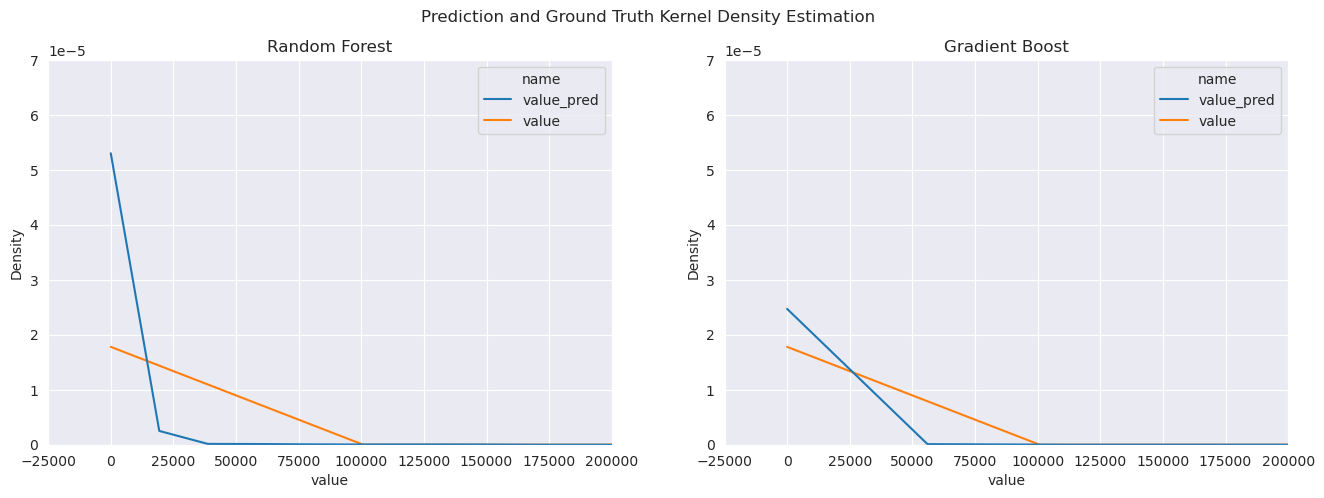

In [76]:
RF_model,GB_model = transformation_comparison(
    targetCol  = "value",
    featureCol = feature_col,
    data_pipeline = data_pipeline_list,
    train_set = train,
    test_set  = test,
    area_col_name = "square_feet",
    log_transform = False,
    per_unit = False
)

The RMSLE for fixed data splitting
(Log:True | Per Unit:False)
(Random Forest) 	1.45
(Gradient Boost)	1.28


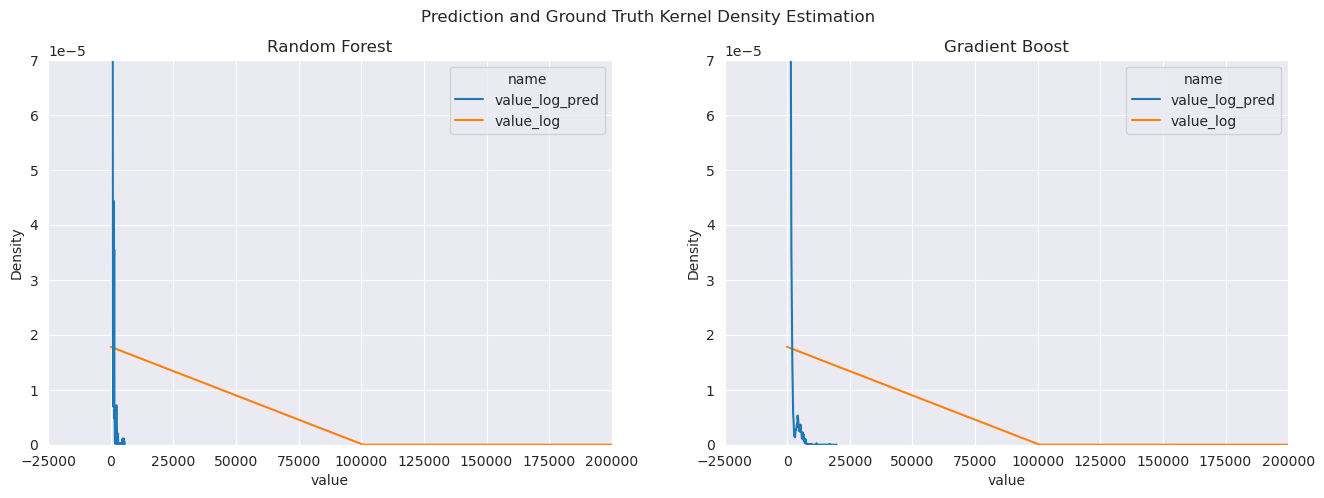

In [77]:
RF_model,GB_model = transformation_comparison(
    targetCol  = "value_log",
    featureCol = feature_col,
    data_pipeline = data_pipeline_list,
    train_set = train,
    test_set  = test,
    area_col_name = "square_feet",
    log_transform = True,
    per_unit = False
)

In [78]:
%%time
### Model Fitting
RF_cv_model = RF_cv_pipeline.fit(dataset=fit_dataset)

CPU times: user 79.3 ms, sys: 64.1 ms, total: 143 ms
Wall time: 22.5 s


In [79]:
%%time
### Model Fitting
GB_cv_model = GB_cv_pipeline.fit(dataset=fit_dataset)

CPU times: user 87.8 ms, sys: 95.5 ms, total: 183 ms
Wall time: 1min 29s


In [80]:
print(f"Average RMSLE across {n_fold}-fold:")
print(f"(Random Forest) \t {RF_cv_model.stages[-1].avgMetrics[0]:.2f}")
print(f"(Gradient Boost)\t {GB_cv_model.stages[-1].avgMetrics[0]:.2f}")

Average RMSLE across 3-fold:
(Random Forest) 	 2.32
(Gradient Boost)	 1.87


Although the log-transformed target yields a lower RMSLE, its predicted distribution is relatively poor, so I decided to use the original (non-log) target variable for modeling.

As for model selection, based on three-fold cross-validation and fixed data splits, Gradient Boosting shows superior performance in both prediction accuracy and distribution matching compared to Random Forest. Therefore, I will choose Gradient Boosting.

### **2.3.3	Model Persistence**

In [25]:
### Library
from pyspark.ml import PipelineModel

In [83]:
### Params Definition
## Path
model_path = "../best_model_before_finetune"
## Model to save
model_save = GB_cv_model

In [84]:
### Checking Pipeline
print(f"The pipeline is:")
for _stage in GB_cv_model.stages:
    print(f"\t{_stage}")

The pipeline is:
	StringIndexerModel: uid=StringIndexer_45df5cfb221e, handleInvalid=error, numInputCols=1, numOutputCols=1
	OneHotEncoderModel: uid=OneHotEncoder_61e342fdd347, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1
	VectorAssembler_f23972d4edea
	StandardScalerModel: uid=StandardScaler_54587e163a98, numFeatures=22, withMean=true, withStd=true
	CrossValidatorModel_e55bccf38e43


In [85]:
### Checking Best Model
print(f"The best model is:")
for _stage,_param in GB_cv_model.stages[-1].bestModel.extractParamMap().items():
    print(f"\tparam:{_stage}")
    print(f"\tvalue:{_param}")

The best model is:
	param:GBTRegressor_cb6135b3e9cf__cacheNodeIds
	value:False
	param:GBTRegressor_cb6135b3e9cf__checkpointInterval
	value:10
	param:GBTRegressor_cb6135b3e9cf__featureSubsetStrategy
	value:all
	param:GBTRegressor_cb6135b3e9cf__featuresCol
	value:scaledFeatures
	param:GBTRegressor_cb6135b3e9cf__impurity
	value:variance
	param:GBTRegressor_cb6135b3e9cf__labelCol
	value:value
	param:GBTRegressor_cb6135b3e9cf__leafCol
	value:
	param:GBTRegressor_cb6135b3e9cf__lossType
	value:squared
	param:GBTRegressor_cb6135b3e9cf__maxBins
	value:32
	param:GBTRegressor_cb6135b3e9cf__maxDepth
	value:5
	param:GBTRegressor_cb6135b3e9cf__maxIter
	value:20
	param:GBTRegressor_cb6135b3e9cf__maxMemoryInMB
	value:2048
	param:GBTRegressor_cb6135b3e9cf__minInfoGain
	value:0.0
	param:GBTRegressor_cb6135b3e9cf__minInstancesPerNode
	value:1
	param:GBTRegressor_cb6135b3e9cf__minWeightFractionPerNode
	value:0.0
	param:GBTRegressor_cb6135b3e9cf__predictionCol
	value:value_pred
	param:GBTRegressor_cb6135b3

In [86]:
### Model Saving
# I learn 'overwrite' by:
#   1. https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.PipelineModel.html?highlight=pipeline%20write#pyspark.ml.PipelineModel.write
#   2. https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.util.MLWriter.html?highlight=overwrite#pyspark.ml.util.MLWriter.overwrite
model_save.write().overwrite().save(path=model_path)

In [87]:
### Testing Loading
pipelineModel = PipelineModel.load(path=model_path)

In [88]:
### Checking Pipeline
print(f"The pipeline is:")
for _stage in pipelineModel.stages:
    print(f"\t{_stage}")

The pipeline is:
	StringIndexerModel: uid=StringIndexer_45df5cfb221e, handleInvalid=error, numInputCols=1, numOutputCols=1
	OneHotEncoderModel: uid=OneHotEncoder_61e342fdd347, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1
	VectorAssembler_f23972d4edea
	StandardScalerModel: uid=StandardScaler_54587e163a98, numFeatures=22, withMean=true, withStd=true
	CrossValidatorModel_e55bccf38e43


In [89]:
### Checking Best Model
print(f"The best model is:")
for _stage,_param in pipelineModel.stages[-1].bestModel.extractParamMap().items():
    print(f"\tparam:{_stage}")
    print(f"\tvalue:{_param}")

The best model is:
	param:GBTRegressor_cb6135b3e9cf__cacheNodeIds
	value:False
	param:GBTRegressor_cb6135b3e9cf__checkpointInterval
	value:10
	param:GBTRegressor_cb6135b3e9cf__featureSubsetStrategy
	value:all
	param:GBTRegressor_cb6135b3e9cf__featuresCol
	value:scaledFeatures
	param:GBTRegressor_cb6135b3e9cf__impurity
	value:variance
	param:GBTRegressor_cb6135b3e9cf__labelCol
	value:value
	param:GBTRegressor_cb6135b3e9cf__leafCol
	value:
	param:GBTRegressor_cb6135b3e9cf__lossType
	value:squared
	param:GBTRegressor_cb6135b3e9cf__maxBins
	value:32
	param:GBTRegressor_cb6135b3e9cf__maxDepth
	value:5
	param:GBTRegressor_cb6135b3e9cf__maxIter
	value:20
	param:GBTRegressor_cb6135b3e9cf__maxMemoryInMB
	value:2048
	param:GBTRegressor_cb6135b3e9cf__minInfoGain
	value:0.0
	param:GBTRegressor_cb6135b3e9cf__minInstancesPerNode
	value:1
	param:GBTRegressor_cb6135b3e9cf__minWeightFractionPerNode
	value:0.0
	param:GBTRegressor_cb6135b3e9cf__predictionCol
	value:value_pred
	param:GBTRegressor_cb6135b3

---

# **Part 3. Fine Tuning**

In [26]:
### Library
import numpy as np
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable, Identifiable

In [33]:
### Params Grid definition
# Making empty params grid
param_grid01 = (
    ParamGridBuilder().
    baseOn({GB_estimator.predictionCol: target_col}).
    baseOn({GB_estimator.predictionCol: f"{target_col}_pred"}).
    # I learn numpy.linspace from
    # link: https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace
    # it will include the edge of the interval
    # For example:
    #   numpy.linspace(start=0.8, stop=1.0, num=3) = numpu.array([0.8, 0.9, 1.0])
    # maxDepth controls the maximum depth of a single decision tree.
    # A deeper tree can model more complex relationships, but it also increases the risk of overfitting.
    addGrid(param=GB_estimator.maxDepth, values=np.linspace(start=8, stop=10, num=3)).
    # maxIter controls how many boosting rounds are allowed — i.e., the maximum number of trees that can be generated.
    # More trees mean the Gradient Boost regressor can correct more initial bias.
    # However, more trees also bring large training costs and higher overfitting risk.
    addGrid(param=GB_estimator.maxIter, values=np.linspace(start=20, stop=30, num=3)).
    # stepSize here refers to the proportion of each new tree’s prediction (on the residuals) that gets added to the overall model.
    # The larger the stepSize, the greater the correction each tree contributes.
    # A too large stepSize can make learning unstable, while a too small stepSize requires many more iterations to achieve good performance.
    addGrid(param=GB_estimator.stepSize, values=[0.2,0.1,0.05]).
    build()
)

In [27]:
### CV params
n_fold = 3 # Lower the folds to speed up the tuning process
n_parallel = 1
evaluator  = RMSLE(predictionCol=f"{target_col}_pred", labelCol=target_col)
fit_dataset = feature_df04
estimator = GB_estimator

In [35]:
### CV pipeline
# Params:
#   estimator: Optional[Estimator] = None,
#   estimatorParamMaps: Optional[List["ParamMap"]] = None,
#   evaluator: Optional[Evaluator] = None,
#   numFolds: int = 3,
#   seed: Optional[int] = None,
#   parallelism: int = 1,
#   collectSubModels: bool = False,
#   foldCol: str = "",
# From: https://spark.apache.org/docs/3.5.0/api/python/_modules/pyspark/ml/tuning.html#CrossValidator
# Gradient Boost
cv = CrossValidator(
    numFolds  = n_fold,
    estimator = estimator,
    evaluator = evaluator,
    parallelism = n_parallel,
    estimatorParamMaps = param_grid01
)
cv_Pipeline = Pipeline(stages = data_pipeline_list + [cv])

In [36]:
%%time
### Model Fitting
cv_model = cv_Pipeline.fit(dataset=fit_dataset)
# CPU times: user 1.87 s, sys: 1.39 s, total: 3.26 s
# Wall time: 24min 25s

CPU times: user 1.71 s, sys: 1.22 s, total: 2.93 s
Wall time: 21min 33s


In [37]:
save_model = cv_model
model_path = "../fine_tuning_step_one"
save_model.write().overwrite().save(path=model_path)

In [38]:
print(f"The lowest RMSLE is {min(cv_model.stages[-1].avgMetrics):.2f}")
# The lowest RMSLE is 1.33

The lowest RMSLE is 1.33


In [39]:
### Checking Best Model
print(f"The params is:")
for _stage,_param in cv_model.stages[-1].bestModel.extractParamMap().items():
    print(f"\tparam:{_stage}")
    print(f"\tvalue:{_param}")
    print("-"*50)

The params is:
	param:GBTRegressor_751f345e5f18__cacheNodeIds
	value:False
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__checkpointInterval
	value:10
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__featureSubsetStrategy
	value:all
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__featuresCol
	value:scaledFeatures
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__impurity
	value:variance
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__labelCol
	value:value
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__leafCol
	value:
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__lossType
	value:squared
--------------------------------------------------
	param:GBTRegressor_751f345e5f18__maxBins
	value:32
--------------------------------------------

In [88]:
# Get the name
pipeline_data = Pipeline(stages=data_pipeline_list)
training_data = pipeline_data.fit(feature_df04).transform(feature_df04)
col_idx_pair = training_data.schema["features"].metadata["ml_attr"]['attrs']
key_name_pair = col_idx_pair['binary']\
                + col_idx_pair['numeric']\
                + [{"idx":_dict["idx"],"name":_dict["name"]} for _dict in col_idx_pair['nominal']]
names = [_name["name"] for _name in sorted(key_name_pair,key=lambda x:x["idx"])]

importance = cv_model.stages[-1].bestModel.featureImportances
importance_dict = dict(zip(importance.indices,importance.values))
print("The importance for each column are:")
for (_importance,_name) in zip(importance_dict.values(),names):
    print(f"\tcolum:{_name}")
    print(f"\tvalue:{_importance:.5f}")
    print("-"*50)

The importance for each column are:
	colum:primary_use_modify_oneh_Education
	value:0.00026
--------------------------------------------------
	colum:primary_use_modify_oneh_Office
	value:0.00015
--------------------------------------------------
	colum:primary_use_modify_oneh_Residential
	value:0.00000
--------------------------------------------------
	colum:primary_use_modify_oneh_Entertainment
	value:0.00003
--------------------------------------------------
	colum:floor_count_bucket
	value:0.00030
--------------------------------------------------
	colum:start_hour
	value:0.01747
--------------------------------------------------
	colum:avg_sea_level_pressure_impute
	value:0.04208
--------------------------------------------------
	colum:latent_s_bucket
	value:0.00008
--------------------------------------------------
	colum:avg_air_temperature_impute
	value:0.03961
--------------------------------------------------
	colum:latent_y_bucket
	value:0.02900
---------------------------